## Part 1: Network Training

### Step0: Import Package & Hyperparameter Configuration

In [1]:
%reset -f

import os
import torch
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 3000
    BATCH_SIZE = 128
    LEARNING_RATE = 0.002  #論文提供
    LR_SCHEDULER_GAMMA = 0.99  #論文提供
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 500
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30


# Reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
material = "Material A"

# 定義保存模型的路徑
model_save_dir = "./Model/"
os.makedirs(model_save_dir, exist_ok=True)  # 如果路徑不存在，創建路徑

# 定義模型保存檔名
model_save_path = os.path.join(model_save_dir, f"{material}.pt")

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step1: Data processing and data loader generate 

In [4]:
# %% Preprocess data into a data loader
def get_dataloader(data_B, data_F, data_T, data_H, data_Pcv, norm, n_init=16):
    """ #*(Date:250105)
    Process data and return DataLoader for training, validation, and testing.

    Parameters
    ----------
    data_B : np.array
        Magnetic flux density data.
    data_F : np.array
        Frequency data.
    data_T : np.array
        Temperature data.
    data_H : np.array
        Magnetic field strength data.
    data_Pcv : np.array
        Core loss data.
    norm : list
        Normalization parameters for the features.
    n_init : int
        Number of initial data points for magnetization.

    Returns
    -------
    train_loader, valid_loader, test_loader : DataLoader
        Dataloaders for training, validation, and testing sets.
    """

    # Data pre-process
    # 1. Down-sample to 128 points
    seq_length = 128
    cols = range(0, 1024, int(1024 / seq_length))  #range(start, stop, step)
    data_B = data_B[:, cols]
    data_H = data_H[:, cols]  #*  Add H Down-sample to 128 points (Date:241213)

    # 2. Add extra points for initial magnetization calculation
    data_length = seq_length + n_init
    data_B = np.hstack((data_B, data_B[:, :n_init]))
    data_H = np.hstack(
        (data_H, data_H[:, :n_init]))  #*(Date:241216) MMINN output似乎是128點
    #*(Date:250130) 原始MMINN H有包含n_init

    # 3. Format data into tensors  #*(Date:241216) seq_length=128, data_length=144
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()
    H = torch.from_numpy(data_H).view(-1, data_length, 1).float()
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # 4. Data Normalization
    in_B = (B - norm[0][0]) / norm[0][1]
    out_H = (H - norm[1][0]) / norm[1][1]
    in_T = (T - norm[3][0]) / norm[3][1]
    in_F = (F - norm[2][0]) / norm[2][1]
    in_Pcv = (Pcv - norm[5][0]) / norm[5][1]

    # 5. Extra features
    dB = torch.diff(B, dim=1)
    dB = torch.cat((dB[:, 0:1], dB), dim=1)
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))

    in_dB = torch.diff(B, dim=1)
    in_dB = torch.cat((in_dB[:, 0:1], in_dB), dim=1)

    in_dB_dt = (dB_dt - norm[4][0]) / norm[4][1]

    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)

    s0 = get_operator_init(in_B[:, 0] - in_dB[:, 0], in_dB, max_B, min_B)

    # 6. Create dataloader to speed up data processing
    full_dataset = torch.utils.data.TensorDataset(
        torch.cat((in_B, in_dB, in_dB_dt), dim=2),  # B 部分（144 點）
        torch.cat((in_F, in_T, in_Pcv), dim=1),  # 輔助變量
        s0,  # 初始狀態
        out_H)

    # Split dataset into train, validation, and test sets (60:20:20)
    train_size = int(0.8 * len(full_dataset))
    valid_size = len(full_dataset) - train_size

    train_dataset, valid_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, valid_size],
        generator=torch.Generator().manual_seed(Config.SEED))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0,
                                               collate_fn=filter_input)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0,
                                               collate_fn=filter_input)

    return train_loader, valid_loader


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=5,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, s0, target_H = zip(*batch)

    # 如果 inputs 是 tuple，先堆疊成張量
    inputs = torch.stack(inputs)  # B 的所有輸入部分（144 點）

    # 保留 in_B, in_dB, in_dB_dt 作為模型輸入
    inputs = inputs[:, :, :3]

    # 保留 features（包括 in_F 和 in_T）
    features = torch.stack(features)[:, :2]

    # 保留目標值 H
    target_H = torch.stack(target_H)[:, -128:, :]  # 只取最後 128 點

    s0 = torch.stack(s0)  # 初始狀態

    return inputs, features, s0, target_H


In [5]:
# %%
# Material normalization data (1.B 2.H 3.F 4.T 5.dB/dt 6.Pv)
normsDict = {
    "Material A": [[-4.02296069e-19, 6.42790612e-02],
                   [1.15118525e-01, 1.22041107e+01],
                   [5.16368866e+00, 2.68540382e-01],
                   [5.52569885e+01, 2.61055470e+01],
                   [2.42224485e-01, 2.37511802e+00],
                   [4.94751596e+00, 8.27844262e-01]],
    "Material B": [[6.75135623e-20, 6.27030179e-02],
                   [3.95575739e-02, 7.62486081e+00],
                   [5.26432657e+00, 2.88519919e-01],
                   [5.80945930e+01, 2.40673885e+01],
                   [2.72521585e-01, 2.46433449e+00],
                   [5.05083704e+00, 7.10303366e-01]],
    "Material C": [[-7.61633305e-19, 7.95720905e-02],
                   [1.11319124e-01, 1.30629103e+01],
                   [5.18559408e+00, 2.68714815e-01],
                   [5.84123573e+01, 2.40717468e+01],
                   [3.26634765e-01, 3.03949690e+00],
                   [4.74633312e+00, 8.05532336e-01]],
    "Material D": [[-3.82835526e-18, 8.10498434e-02],
                   [-1.14488902e-02, 2.83868927e+01],
                   [5.25141287e+00, 2.50821203e-01],
                   [6.72413788e+01, 2.59518223e+01],
                   [3.00584078e-01, 3.24369454e+00],
                   [5.01819372e+00, 8.41059685e-01]],
    "Material E": [[-4.22607249e-18, 1.28762770e-01],
                   [3.88389004e-01, 4.80431443e+01],
                   [5.18909550e+00, 2.77695119e-01],
                   [5.64505730e+01, 2.46127701e+01],
                   [6.35038793e-01, 5.19237566e+00],
                   [5.68955612e+00, 7.26979315e-01]]
}

### Step2: Define Network Structure

In [6]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt)
    - var_size: number of supplenmentary variables (1.F 2.T)        
    - output_size: number of outputs (1.H)
"""


class MMINet(nn.Module):

    def __init__(self,
                 Material,
                 hidden_size=Config.HIDDEN_SIZE,
                 operator_size=Config.OPERATOR_SIZE,
                 input_size=3,
                 var_size=2,
                 output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = normsDict[Material]

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + 2, 1)
        self.rnn2 = EddyCell(4, self.hidden_size, output_size)
        self.dnn2 = nn.Linear(self.hidden_size, 1)

        self.rnn2_hx = None

    def forward(self, x, var, s0, n_init=16):
        """
         Parameters: 
          - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
          - var(batch,var_size): Supplementary inputs (1.F 2.T)
          - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # Initialize DNN2 input (1.B 2.dB/dt)
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        H = (output[:, n_init:, :])

        return H


class StopOperatorCell():

    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(5 / operator_size, 5, operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):

    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden

### Step3: Training the Model

In [7]:
# %%
def load_dataset(material, base_path="./Data/Training/"):
    in_file1 = f"{base_path}{material}/B_Field.csv"
    in_file2 = f"{base_path}{material}/Frequency.csv"
    in_file3 = f"{base_path}{material}/Temperature.csv"
    in_file4 = f"{base_path}{material}/H_Field.csv"
    in_file5 = f"{base_path}{material}/Volumetric_Loss.csv"

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N by 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N by 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N by 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N by 1024
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N by 1

    return data_B, data_F, data_T, data_H, data_Pcv


In [8]:
# %%
def train_model(train_loader, valid_loader):

    model = MMINet(Material=material).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

    best_val_loss = float('inf')
    patience_counter = 0

    # 定義保存路徑
    model_save_path = os.path.join("./Model/", f"{material}.pt")

    for epoch in range(Config.NUM_EPOCHS):
        model.train()
        train_loss = 0

        for inputs, features, s0, target_H in train_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, features, s0)  # 模型的輸出
            loss = criterion(outputs, target_H)  # 使用真實的 H(t) 計算損失
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for inputs, features, s0, target_H in valid_loader:
                inputs, features, s0, target_H = inputs.to(
                    device), features.to(device), s0.to(device), target_H.to(
                        device)
                outputs = model(inputs, features, s0)
                loss = criterion(outputs, target_H)
                val_loss += loss.item()

        val_loss /= len(valid_loader)

        print(
            f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}"
        )
        # *======================================================Debug用======================================================
        plot_interval = 50
        if (epoch + 1) % plot_interval == 0:
            outputs = outputs[:3].detach().cpu().numpy()
            targets = target_H[:3].detach().cpu().numpy()

            # 設定圖表
            plt.figure(figsize=(12, 6))

            for i in range(outputs.shape[0]):  # 每一批數據繪製一個圖表
                plt.plot(outputs[i, :, 0],
                         label=f"Pred: Sample {i+1}",
                         linestyle='--',
                         marker='o')
                plt.plot(targets[i, :, 0],
                         label=f"Target: Sample {i+1}",
                         linestyle='-',
                         marker='x')

            # 添加標題和標籤
            plt.title(f"Compare - Epoch {epoch + 1}", fontsize=16)
            plt.xlabel("Index", fontsize=14)
            plt.ylabel("Value", fontsize=14)
            plt.legend(loc="upper right", fontsize=12)
            plt.grid(alpha=0.5)

            # 顯示圖表
            plt.show()
        # *======================================================Debug用 END ======================================================

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)  # 保存最佳模型
            print(
                f"Saving model at epoch {epoch+1} with validation loss {val_loss:.6f}..."
            )
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= Config.EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

    print(f"Training complete. Best model saved at {model_save_path}.")


In [9]:
# 驗證輸入shape
# net = MMINet(Material=material).to(device)
# for inputs, features, s0 in train_loader:
#     print(f"inputs shape: {inputs.shape}")  # 包括 in_B, in_dB, in_dB_dt
#     print(f"features shape: {features.shape}")  # 包括 in_F, in_T
#     print(f"s0 shape: {s0.shape}")  # 初始化狀態向量
#     break

# 驗證輸出shape
# net = MMINet(Material=material).to(device)
# for inputs, features, s0 in train_loader:
#     # 提取輸入數據
#     inputs = inputs.to(device)  # in_B, in_dB, in_dB_dt
#     features = features.to(device)  # in_F, in_T
#     s0 = s0.to(device)  # 初始狀態向量

#     # 將數據傳入模型
#     outputs = net(inputs, features, s0)

#     # 打印輸出形狀與樣本數據
#     print(f"outputs shape: {outputs.shape}")
#     print(f"outputs data: {outputs[0]}")  # 打印第一個樣本的輸出波形數據
#     break


Epoch 1, Train Loss: 0.931223, Validation Loss: 0.869426
Saving model at epoch 1 with validation loss 0.869426...
Epoch 2, Train Loss: 0.745115, Validation Loss: 0.698397
Saving model at epoch 2 with validation loss 0.698397...
Epoch 3, Train Loss: 0.597815, Validation Loss: 0.530695
Saving model at epoch 3 with validation loss 0.530695...
Epoch 4, Train Loss: 0.497983, Validation Loss: 0.442146
Saving model at epoch 4 with validation loss 0.442146...
Epoch 5, Train Loss: 0.438734, Validation Loss: 0.422005
Saving model at epoch 5 with validation loss 0.422005...
Epoch 6, Train Loss: 0.427006, Validation Loss: 0.410563
Saving model at epoch 6 with validation loss 0.410563...
Epoch 7, Train Loss: 0.412839, Validation Loss: 0.398977
Saving model at epoch 7 with validation loss 0.398977...
Epoch 8, Train Loss: 0.399618, Validation Loss: 0.389775
Saving model at epoch 8 with validation loss 0.389775...
Epoch 9, Train Loss: 0.397421, Validation Loss: 0.380984
Saving model at epoch 9 with va

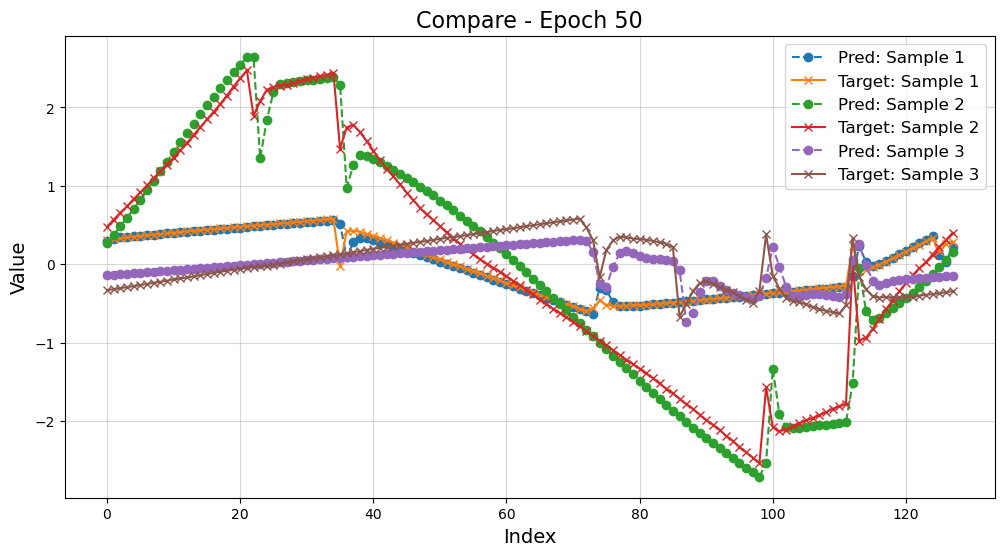

Saving model at epoch 50 with validation loss 0.197629...
Epoch 51, Train Loss: 0.199972, Validation Loss: 0.194607
Saving model at epoch 51 with validation loss 0.194607...
Epoch 52, Train Loss: 0.191278, Validation Loss: 0.192489
Saving model at epoch 52 with validation loss 0.192489...
Epoch 53, Train Loss: 0.195679, Validation Loss: 0.190155
Saving model at epoch 53 with validation loss 0.190155...
Epoch 54, Train Loss: 0.186283, Validation Loss: 0.187316
Saving model at epoch 54 with validation loss 0.187316...
Epoch 55, Train Loss: 0.191376, Validation Loss: 0.184920
Saving model at epoch 55 with validation loss 0.184920...
Epoch 56, Train Loss: 0.184180, Validation Loss: 0.182275
Saving model at epoch 56 with validation loss 0.182275...
Epoch 57, Train Loss: 0.181130, Validation Loss: 0.181816
Saving model at epoch 57 with validation loss 0.181816...
Epoch 58, Train Loss: 0.187778, Validation Loss: 0.178929
Saving model at epoch 58 with validation loss 0.178929...
Epoch 59, Trai

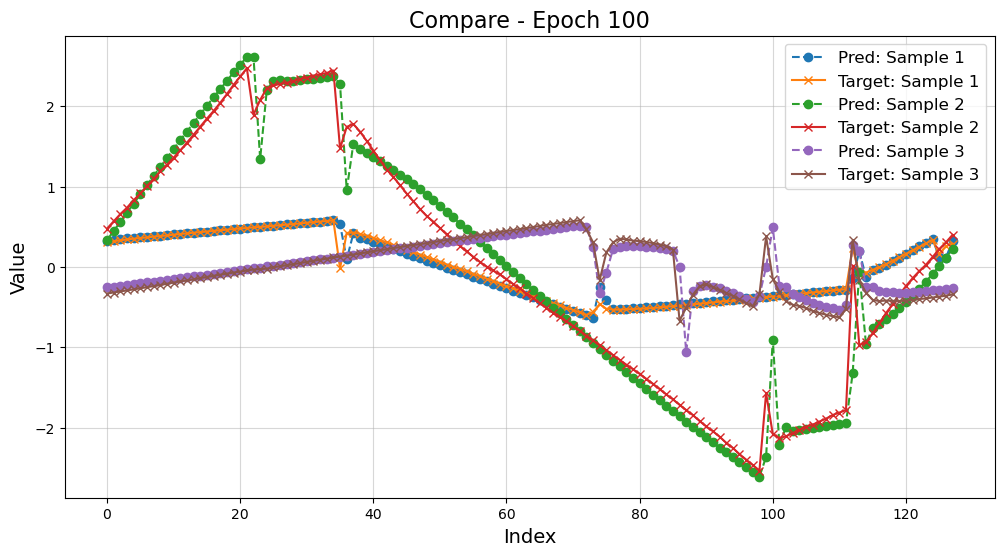

Saving model at epoch 100 with validation loss 0.122645...
Epoch 101, Train Loss: 0.117751, Validation Loss: 0.121327
Saving model at epoch 101 with validation loss 0.121327...
Epoch 102, Train Loss: 0.116516, Validation Loss: 0.120283
Saving model at epoch 102 with validation loss 0.120283...
Epoch 103, Train Loss: 0.121794, Validation Loss: 0.119592
Saving model at epoch 103 with validation loss 0.119592...
Epoch 104, Train Loss: 0.114906, Validation Loss: 0.119062
Saving model at epoch 104 with validation loss 0.119062...
Epoch 105, Train Loss: 0.114425, Validation Loss: 0.118502
Saving model at epoch 105 with validation loss 0.118502...
Epoch 106, Train Loss: 0.112516, Validation Loss: 0.118274
Saving model at epoch 106 with validation loss 0.118274...
Epoch 107, Train Loss: 0.114133, Validation Loss: 0.116890
Saving model at epoch 107 with validation loss 0.116890...
Epoch 108, Train Loss: 0.117142, Validation Loss: 0.116532
Saving model at epoch 108 with validation loss 0.116532.

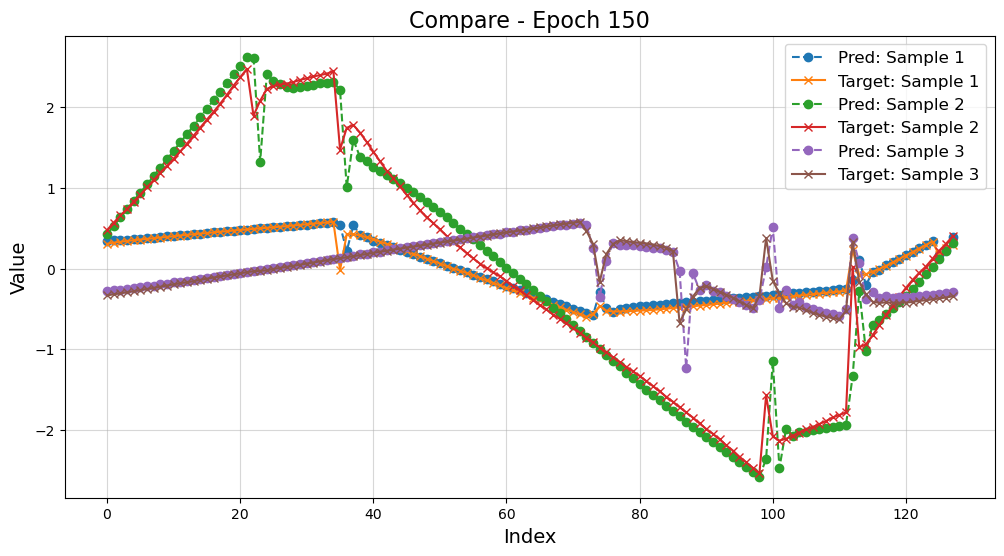

Saving model at epoch 150 with validation loss 0.099534...
Epoch 151, Train Loss: 0.093167, Validation Loss: 0.099985
Epoch 152, Train Loss: 0.092740, Validation Loss: 0.098750
Saving model at epoch 152 with validation loss 0.098750...
Epoch 153, Train Loss: 0.094956, Validation Loss: 0.099201
Epoch 154, Train Loss: 0.091452, Validation Loss: 0.098934
Epoch 155, Train Loss: 0.093264, Validation Loss: 0.099496
Epoch 156, Train Loss: 0.092105, Validation Loss: 0.098248
Saving model at epoch 156 with validation loss 0.098248...
Epoch 157, Train Loss: 0.091356, Validation Loss: 0.097961
Saving model at epoch 157 with validation loss 0.097961...
Epoch 158, Train Loss: 0.091798, Validation Loss: 0.097979
Epoch 159, Train Loss: 0.089761, Validation Loss: 0.097278
Saving model at epoch 159 with validation loss 0.097278...
Epoch 160, Train Loss: 0.092637, Validation Loss: 0.097093
Saving model at epoch 160 with validation loss 0.097093...
Epoch 161, Train Loss: 0.093081, Validation Loss: 0.0981

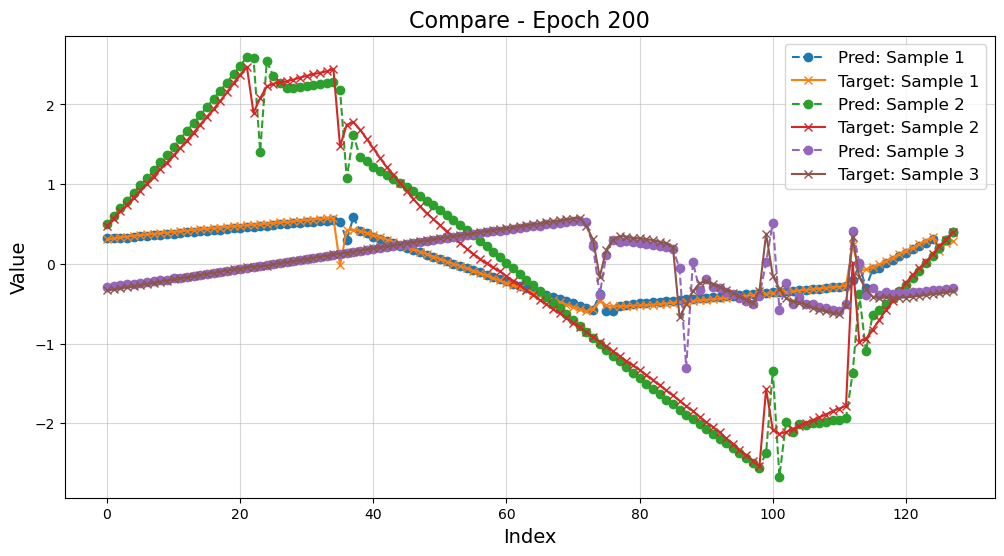

Saving model at epoch 200 with validation loss 0.090738...
Epoch 201, Train Loss: 0.085551, Validation Loss: 0.090934
Epoch 202, Train Loss: 0.085869, Validation Loss: 0.091883
Epoch 203, Train Loss: 0.084053, Validation Loss: 0.090354
Saving model at epoch 203 with validation loss 0.090354...
Epoch 204, Train Loss: 0.083744, Validation Loss: 0.091627
Epoch 205, Train Loss: 0.085204, Validation Loss: 0.090321
Saving model at epoch 205 with validation loss 0.090321...
Epoch 206, Train Loss: 0.085125, Validation Loss: 0.090298
Saving model at epoch 206 with validation loss 0.090298...
Epoch 207, Train Loss: 0.083354, Validation Loss: 0.090912
Epoch 208, Train Loss: 0.083846, Validation Loss: 0.095573
Epoch 209, Train Loss: 0.086487, Validation Loss: 0.089792
Saving model at epoch 209 with validation loss 0.089792...
Epoch 210, Train Loss: 0.083970, Validation Loss: 0.089571
Saving model at epoch 210 with validation loss 0.089571...
Epoch 211, Train Loss: 0.084153, Validation Loss: 0.0894

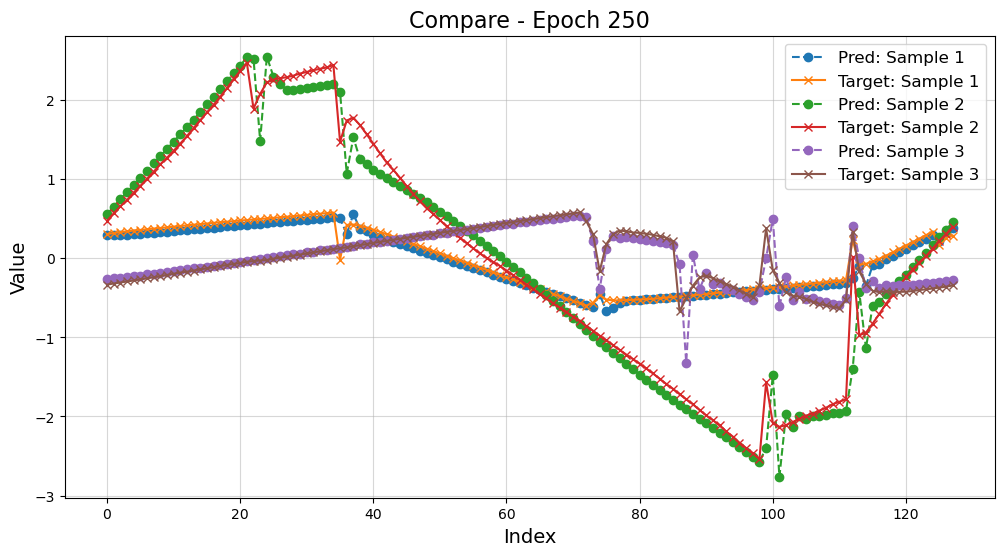

Epoch 251, Train Loss: 0.079496, Validation Loss: 0.086261
Saving model at epoch 251 with validation loss 0.086261...
Epoch 252, Train Loss: 0.078807, Validation Loss: 0.089038
Epoch 253, Train Loss: 0.081931, Validation Loss: 0.089564
Epoch 254, Train Loss: 0.078221, Validation Loss: 0.086143
Saving model at epoch 254 with validation loss 0.086143...
Epoch 255, Train Loss: 0.078148, Validation Loss: 0.086383
Epoch 256, Train Loss: 0.079104, Validation Loss: 0.086487
Epoch 257, Train Loss: 0.079359, Validation Loss: 0.085877
Saving model at epoch 257 with validation loss 0.085877...
Epoch 258, Train Loss: 0.079391, Validation Loss: 0.086524
Epoch 259, Train Loss: 0.080717, Validation Loss: 0.086279
Epoch 260, Train Loss: 0.081052, Validation Loss: 0.086035
Epoch 261, Train Loss: 0.078534, Validation Loss: 0.085699
Saving model at epoch 261 with validation loss 0.085699...
Epoch 262, Train Loss: 0.082547, Validation Loss: 0.086339
Epoch 263, Train Loss: 0.081763, Validation Loss: 0.0861

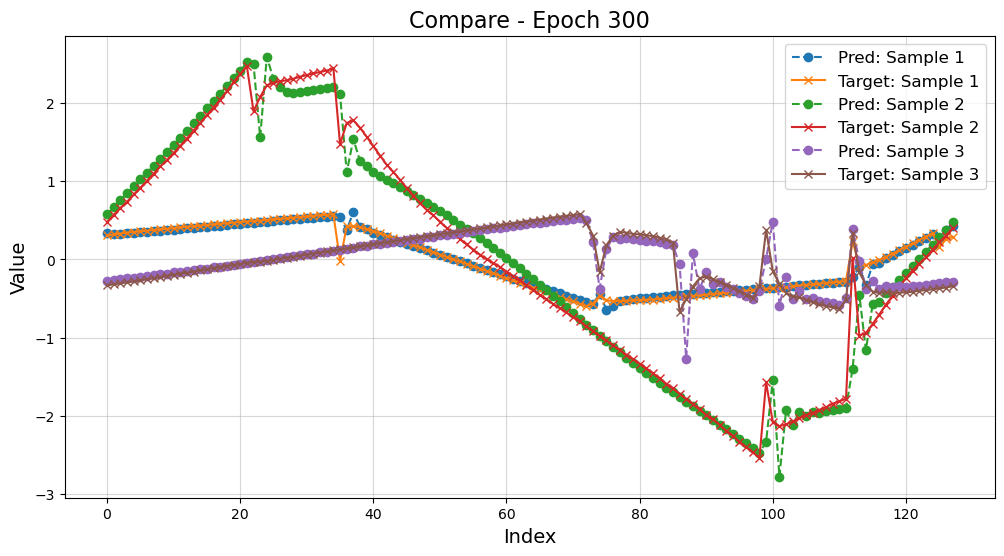

Saving model at epoch 300 with validation loss 0.083505...
Epoch 301, Train Loss: 0.074989, Validation Loss: 0.083565
Epoch 302, Train Loss: 0.076533, Validation Loss: 0.083356
Saving model at epoch 302 with validation loss 0.083356...
Epoch 303, Train Loss: 0.074170, Validation Loss: 0.083602
Epoch 304, Train Loss: 0.074368, Validation Loss: 0.083245
Saving model at epoch 304 with validation loss 0.083245...
Epoch 305, Train Loss: 0.075811, Validation Loss: 0.084076
Epoch 306, Train Loss: 0.075772, Validation Loss: 0.083310
Epoch 307, Train Loss: 0.076902, Validation Loss: 0.083166
Saving model at epoch 307 with validation loss 0.083166...
Epoch 308, Train Loss: 0.076864, Validation Loss: 0.083729
Epoch 309, Train Loss: 0.077593, Validation Loss: 0.082517
Saving model at epoch 309 with validation loss 0.082517...
Epoch 310, Train Loss: 0.077940, Validation Loss: 0.082857
Epoch 311, Train Loss: 0.075409, Validation Loss: 0.083462
Epoch 312, Train Loss: 0.074761, Validation Loss: 0.0829

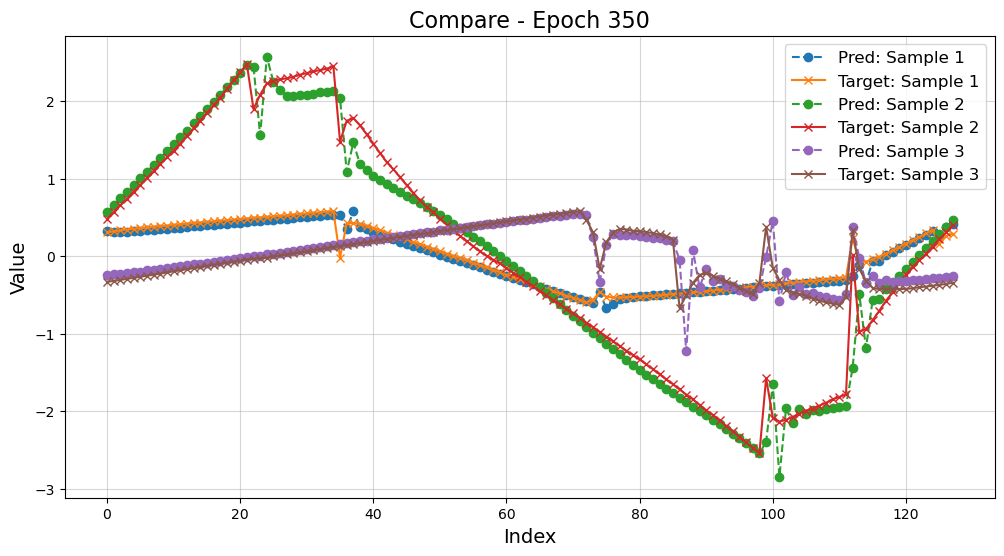

Epoch 351, Train Loss: 0.078189, Validation Loss: 0.081408
Epoch 352, Train Loss: 0.073006, Validation Loss: 0.082177
Epoch 353, Train Loss: 0.072749, Validation Loss: 0.081284
Epoch 354, Train Loss: 0.072799, Validation Loss: 0.081165
Saving model at epoch 354 with validation loss 0.081165...
Epoch 355, Train Loss: 0.077122, Validation Loss: 0.081654
Epoch 356, Train Loss: 0.073368, Validation Loss: 0.081075
Saving model at epoch 356 with validation loss 0.081075...
Epoch 357, Train Loss: 0.073484, Validation Loss: 0.081045
Saving model at epoch 357 with validation loss 0.081045...
Epoch 358, Train Loss: 0.075412, Validation Loss: 0.080975
Saving model at epoch 358 with validation loss 0.080975...
Epoch 359, Train Loss: 0.073417, Validation Loss: 0.081209
Epoch 360, Train Loss: 0.073229, Validation Loss: 0.080749
Saving model at epoch 360 with validation loss 0.080749...
Epoch 361, Train Loss: 0.071993, Validation Loss: 0.080654
Saving model at epoch 361 with validation loss 0.080654.

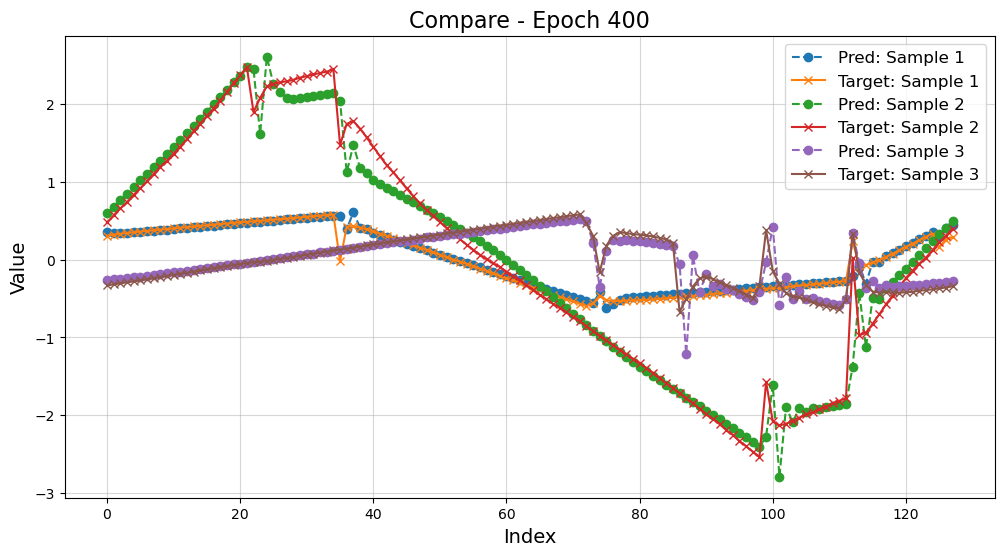

Saving model at epoch 400 with validation loss 0.079384...
Epoch 401, Train Loss: 0.070982, Validation Loss: 0.079187
Saving model at epoch 401 with validation loss 0.079187...
Epoch 402, Train Loss: 0.070403, Validation Loss: 0.079559
Epoch 403, Train Loss: 0.070675, Validation Loss: 0.079205
Epoch 404, Train Loss: 0.072978, Validation Loss: 0.079433
Epoch 405, Train Loss: 0.071156, Validation Loss: 0.080235
Epoch 406, Train Loss: 0.071306, Validation Loss: 0.079176
Saving model at epoch 406 with validation loss 0.079176...
Epoch 407, Train Loss: 0.070200, Validation Loss: 0.081566
Epoch 408, Train Loss: 0.072631, Validation Loss: 0.081108
Epoch 409, Train Loss: 0.073005, Validation Loss: 0.079149
Saving model at epoch 409 with validation loss 0.079149...
Epoch 410, Train Loss: 0.070561, Validation Loss: 0.079456
Epoch 411, Train Loss: 0.069668, Validation Loss: 0.079550
Epoch 412, Train Loss: 0.070479, Validation Loss: 0.079299
Epoch 413, Train Loss: 0.070122, Validation Loss: 0.0791

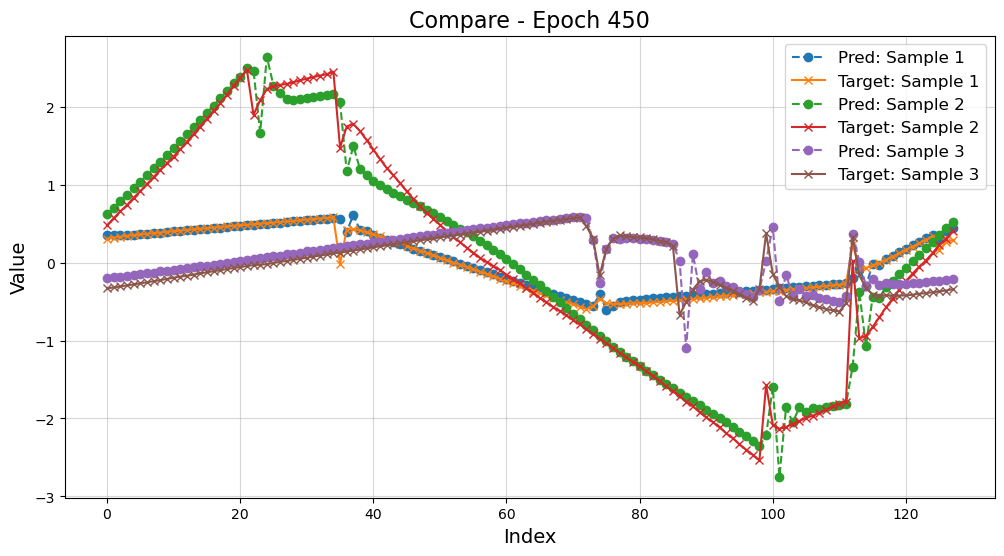

Epoch 451, Train Loss: 0.072546, Validation Loss: 0.080670
Epoch 452, Train Loss: 0.070086, Validation Loss: 0.078390
Epoch 453, Train Loss: 0.069938, Validation Loss: 0.078121
Epoch 454, Train Loss: 0.069266, Validation Loss: 0.078600
Epoch 455, Train Loss: 0.071387, Validation Loss: 0.078655
Epoch 456, Train Loss: 0.069176, Validation Loss: 0.078334
Epoch 457, Train Loss: 0.070120, Validation Loss: 0.078055
Epoch 458, Train Loss: 0.070817, Validation Loss: 0.079432
Epoch 459, Train Loss: 0.069263, Validation Loss: 0.077881
Saving model at epoch 459 with validation loss 0.077881...
Epoch 460, Train Loss: 0.068788, Validation Loss: 0.078333
Epoch 461, Train Loss: 0.072505, Validation Loss: 0.078184
Epoch 462, Train Loss: 0.070160, Validation Loss: 0.078029
Epoch 463, Train Loss: 0.069101, Validation Loss: 0.078493
Epoch 464, Train Loss: 0.071575, Validation Loss: 0.077533
Saving model at epoch 464 with validation loss 0.077533...
Epoch 465, Train Loss: 0.068211, Validation Loss: 0.0794

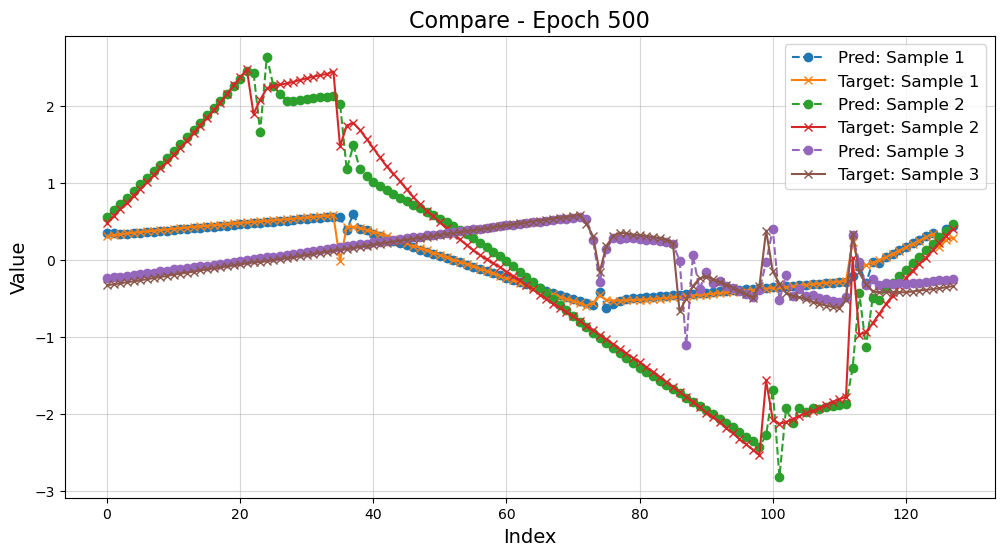

Epoch 501, Train Loss: 0.068803, Validation Loss: 0.077007
Epoch 502, Train Loss: 0.071203, Validation Loss: 0.077605
Epoch 503, Train Loss: 0.071028, Validation Loss: 0.076868
Saving model at epoch 503 with validation loss 0.076868...
Epoch 504, Train Loss: 0.068285, Validation Loss: 0.076707
Saving model at epoch 504 with validation loss 0.076707...
Epoch 505, Train Loss: 0.068071, Validation Loss: 0.076823
Epoch 506, Train Loss: 0.069773, Validation Loss: 0.076672
Saving model at epoch 506 with validation loss 0.076672...
Epoch 507, Train Loss: 0.067946, Validation Loss: 0.076680
Epoch 508, Train Loss: 0.069029, Validation Loss: 0.076684
Epoch 509, Train Loss: 0.067935, Validation Loss: 0.084551
Epoch 510, Train Loss: 0.071612, Validation Loss: 0.078989
Epoch 511, Train Loss: 0.068459, Validation Loss: 0.076646
Saving model at epoch 511 with validation loss 0.076646...
Epoch 512, Train Loss: 0.069903, Validation Loss: 0.077009
Epoch 513, Train Loss: 0.067704, Validation Loss: 0.0769

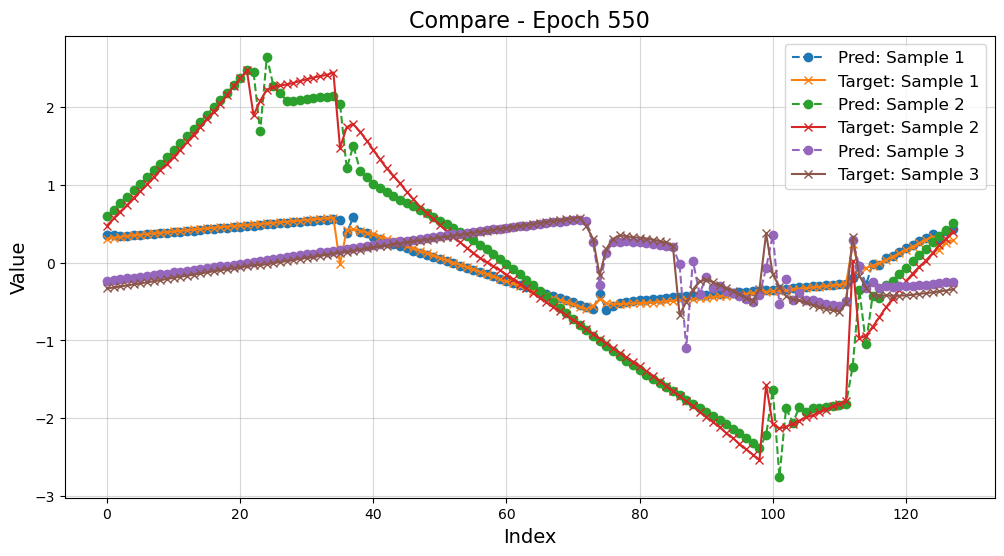

Saving model at epoch 550 with validation loss 0.075980...
Epoch 551, Train Loss: 0.066281, Validation Loss: 0.075602
Saving model at epoch 551 with validation loss 0.075602...
Epoch 552, Train Loss: 0.069283, Validation Loss: 0.076015
Epoch 553, Train Loss: 0.066342, Validation Loss: 0.076083
Epoch 554, Train Loss: 0.066668, Validation Loss: 0.075937
Epoch 555, Train Loss: 0.065986, Validation Loss: 0.076318
Epoch 556, Train Loss: 0.068045, Validation Loss: 0.075716
Epoch 557, Train Loss: 0.066394, Validation Loss: 0.076311
Epoch 558, Train Loss: 0.067032, Validation Loss: 0.076240
Epoch 559, Train Loss: 0.066277, Validation Loss: 0.076634
Epoch 560, Train Loss: 0.067903, Validation Loss: 0.077355
Epoch 561, Train Loss: 0.067699, Validation Loss: 0.076330
Epoch 562, Train Loss: 0.065761, Validation Loss: 0.075844
Epoch 563, Train Loss: 0.065725, Validation Loss: 0.075698
Epoch 564, Train Loss: 0.067877, Validation Loss: 0.076174
Epoch 565, Train Loss: 0.068468, Validation Loss: 0.0794

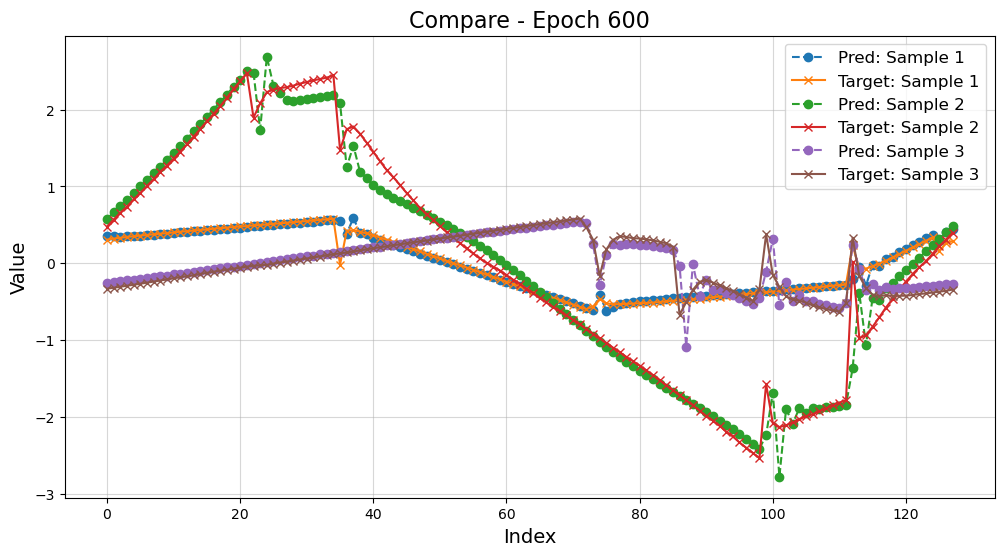

Saving model at epoch 600 with validation loss 0.074915...
Epoch 601, Train Loss: 0.065720, Validation Loss: 0.075299
Epoch 602, Train Loss: 0.065695, Validation Loss: 0.075112
Epoch 603, Train Loss: 0.066486, Validation Loss: 0.074970
Epoch 604, Train Loss: 0.063769, Validation Loss: 0.074806
Saving model at epoch 604 with validation loss 0.074806...
Epoch 605, Train Loss: 0.062992, Validation Loss: 0.074692
Saving model at epoch 605 with validation loss 0.074692...
Epoch 606, Train Loss: 0.063377, Validation Loss: 0.074752
Epoch 607, Train Loss: 0.067436, Validation Loss: 0.075123
Epoch 608, Train Loss: 0.064751, Validation Loss: 0.074923
Epoch 609, Train Loss: 0.064404, Validation Loss: 0.075183
Epoch 610, Train Loss: 0.063911, Validation Loss: 0.075902
Epoch 611, Train Loss: 0.067054, Validation Loss: 0.074811
Epoch 612, Train Loss: 0.064576, Validation Loss: 0.074504
Saving model at epoch 612 with validation loss 0.074504...
Epoch 613, Train Loss: 0.063691, Validation Loss: 0.0752

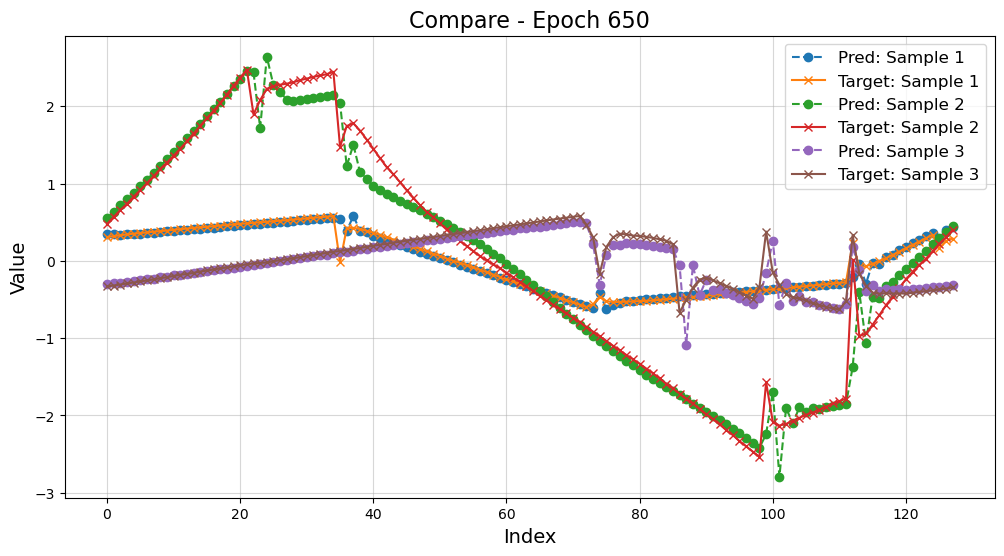

Epoch 651, Train Loss: 0.065173, Validation Loss: 0.075475
Epoch 652, Train Loss: 0.066150, Validation Loss: 0.074763
Epoch 653, Train Loss: 0.064914, Validation Loss: 0.074806
Epoch 654, Train Loss: 0.064783, Validation Loss: 0.073995
Epoch 655, Train Loss: 0.065125, Validation Loss: 0.074353
Epoch 656, Train Loss: 0.065285, Validation Loss: 0.075445
Epoch 657, Train Loss: 0.065116, Validation Loss: 0.074040
Epoch 658, Train Loss: 0.063299, Validation Loss: 0.074302
Epoch 659, Train Loss: 0.063374, Validation Loss: 0.074702
Epoch 660, Train Loss: 0.065368, Validation Loss: 0.074525
Epoch 661, Train Loss: 0.063838, Validation Loss: 0.075239
Epoch 662, Train Loss: 0.063612, Validation Loss: 0.073737
Epoch 663, Train Loss: 0.061910, Validation Loss: 0.075489
Epoch 664, Train Loss: 0.066824, Validation Loss: 0.077191
Epoch 665, Train Loss: 0.063161, Validation Loss: 0.074900
Epoch 666, Train Loss: 0.064828, Validation Loss: 0.073665
Saving model at epoch 666 with validation loss 0.073665.

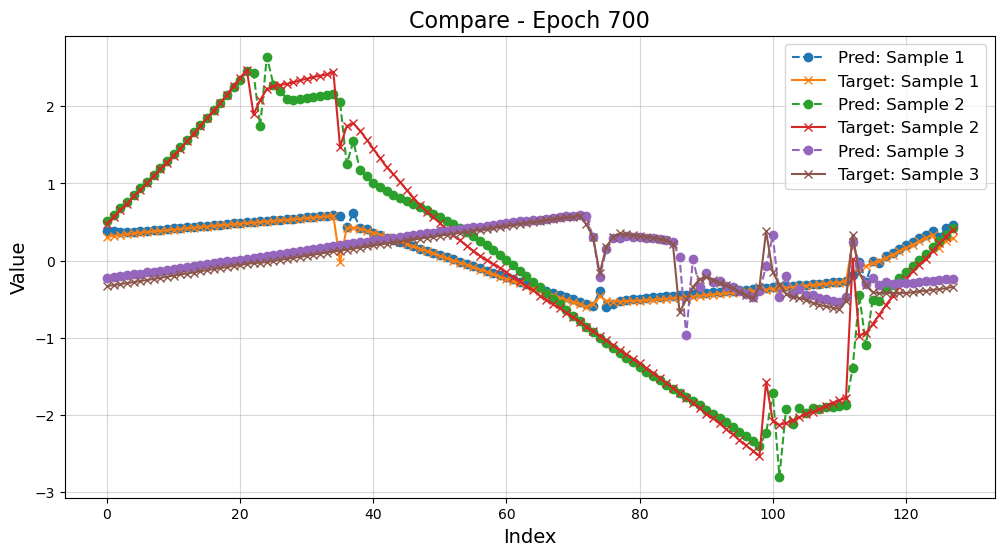

Epoch 701, Train Loss: 0.063348, Validation Loss: 0.075710
Epoch 702, Train Loss: 0.063818, Validation Loss: 0.073791
Epoch 703, Train Loss: 0.063114, Validation Loss: 0.073023
Epoch 704, Train Loss: 0.062194, Validation Loss: 0.072947
Saving model at epoch 704 with validation loss 0.072947...
Epoch 705, Train Loss: 0.063799, Validation Loss: 0.072604
Saving model at epoch 705 with validation loss 0.072604...
Epoch 706, Train Loss: 0.063259, Validation Loss: 0.072617
Epoch 707, Train Loss: 0.062461, Validation Loss: 0.072985
Epoch 708, Train Loss: 0.061231, Validation Loss: 0.072631
Epoch 709, Train Loss: 0.062233, Validation Loss: 0.072846
Epoch 710, Train Loss: 0.062259, Validation Loss: 0.073219
Epoch 711, Train Loss: 0.063792, Validation Loss: 0.075845
Epoch 712, Train Loss: 0.065612, Validation Loss: 0.075333
Epoch 713, Train Loss: 0.062811, Validation Loss: 0.074300
Epoch 714, Train Loss: 0.062344, Validation Loss: 0.072753
Epoch 715, Train Loss: 0.061547, Validation Loss: 0.0730

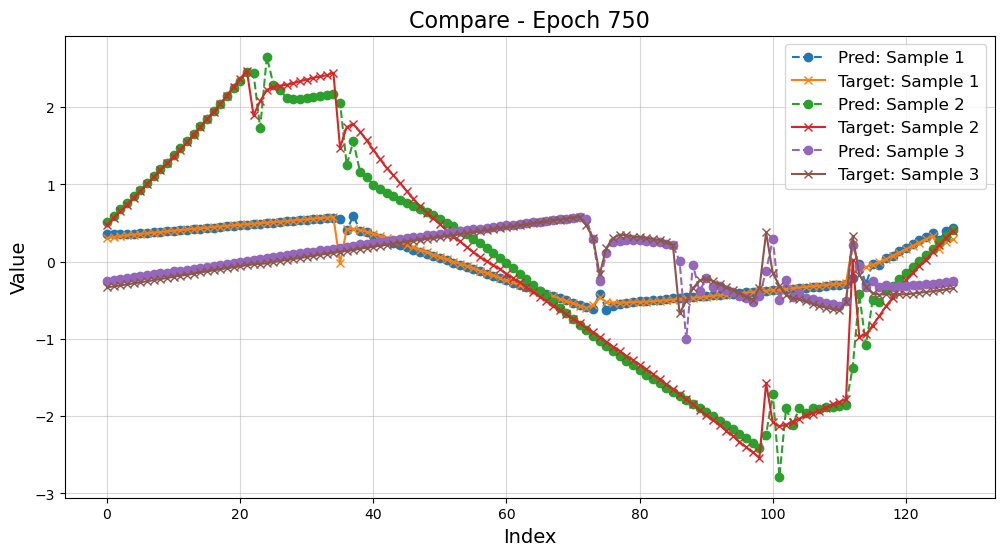

Epoch 751, Train Loss: 0.059842, Validation Loss: 0.072164
Saving model at epoch 751 with validation loss 0.072164...
Epoch 752, Train Loss: 0.060892, Validation Loss: 0.072744
Epoch 753, Train Loss: 0.063156, Validation Loss: 0.072738
Epoch 754, Train Loss: 0.061149, Validation Loss: 0.073555
Epoch 755, Train Loss: 0.061249, Validation Loss: 0.073156
Epoch 756, Train Loss: 0.060384, Validation Loss: 0.071938
Saving model at epoch 756 with validation loss 0.071938...
Epoch 757, Train Loss: 0.060482, Validation Loss: 0.071935
Saving model at epoch 757 with validation loss 0.071935...
Epoch 758, Train Loss: 0.061881, Validation Loss: 0.072107
Epoch 759, Train Loss: 0.060900, Validation Loss: 0.072621
Epoch 760, Train Loss: 0.061496, Validation Loss: 0.071896
Saving model at epoch 760 with validation loss 0.071896...
Epoch 761, Train Loss: 0.061146, Validation Loss: 0.072563
Epoch 762, Train Loss: 0.061285, Validation Loss: 0.072043
Epoch 763, Train Loss: 0.059082, Validation Loss: 0.0723

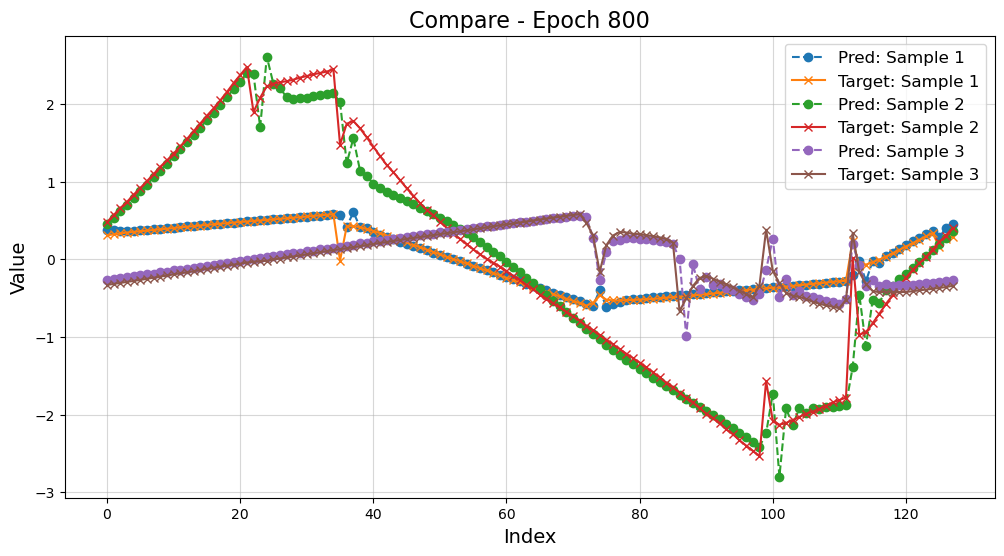

Epoch 801, Train Loss: 0.058825, Validation Loss: 0.071431
Epoch 802, Train Loss: 0.060647, Validation Loss: 0.071157
Saving model at epoch 802 with validation loss 0.071157...
Epoch 803, Train Loss: 0.060730, Validation Loss: 0.071608
Epoch 804, Train Loss: 0.059401, Validation Loss: 0.072222
Epoch 805, Train Loss: 0.060673, Validation Loss: 0.071247
Epoch 806, Train Loss: 0.059253, Validation Loss: 0.071593
Epoch 807, Train Loss: 0.059895, Validation Loss: 0.071596
Epoch 808, Train Loss: 0.061434, Validation Loss: 0.075306
Epoch 809, Train Loss: 0.061131, Validation Loss: 0.072388
Epoch 810, Train Loss: 0.059170, Validation Loss: 0.073234
Epoch 811, Train Loss: 0.059950, Validation Loss: 0.071135
Saving model at epoch 811 with validation loss 0.071135...
Epoch 812, Train Loss: 0.058501, Validation Loss: 0.072183
Epoch 813, Train Loss: 0.060663, Validation Loss: 0.071459
Epoch 814, Train Loss: 0.061004, Validation Loss: 0.071420
Epoch 815, Train Loss: 0.057511, Validation Loss: 0.0711

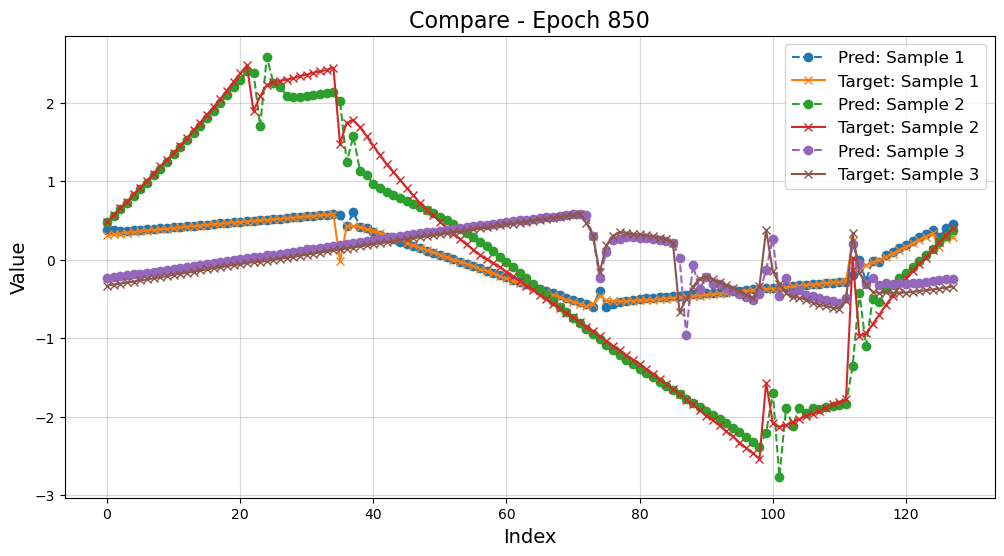

Epoch 851, Train Loss: 0.058562, Validation Loss: 0.070871
Epoch 852, Train Loss: 0.059364, Validation Loss: 0.070768
Epoch 853, Train Loss: 0.061471, Validation Loss: 0.071181
Epoch 854, Train Loss: 0.058949, Validation Loss: 0.070694
Epoch 855, Train Loss: 0.057152, Validation Loss: 0.070776
Epoch 856, Train Loss: 0.058111, Validation Loss: 0.070396
Saving model at epoch 856 with validation loss 0.070396...
Epoch 857, Train Loss: 0.059115, Validation Loss: 0.072652
Epoch 858, Train Loss: 0.059844, Validation Loss: 0.072606
Epoch 859, Train Loss: 0.058163, Validation Loss: 0.070603
Epoch 860, Train Loss: 0.060583, Validation Loss: 0.071231
Epoch 861, Train Loss: 0.057194, Validation Loss: 0.071066
Epoch 862, Train Loss: 0.058453, Validation Loss: 0.070582
Epoch 863, Train Loss: 0.057358, Validation Loss: 0.070380
Saving model at epoch 863 with validation loss 0.070380...
Epoch 864, Train Loss: 0.059040, Validation Loss: 0.070640
Epoch 865, Train Loss: 0.059642, Validation Loss: 0.0705

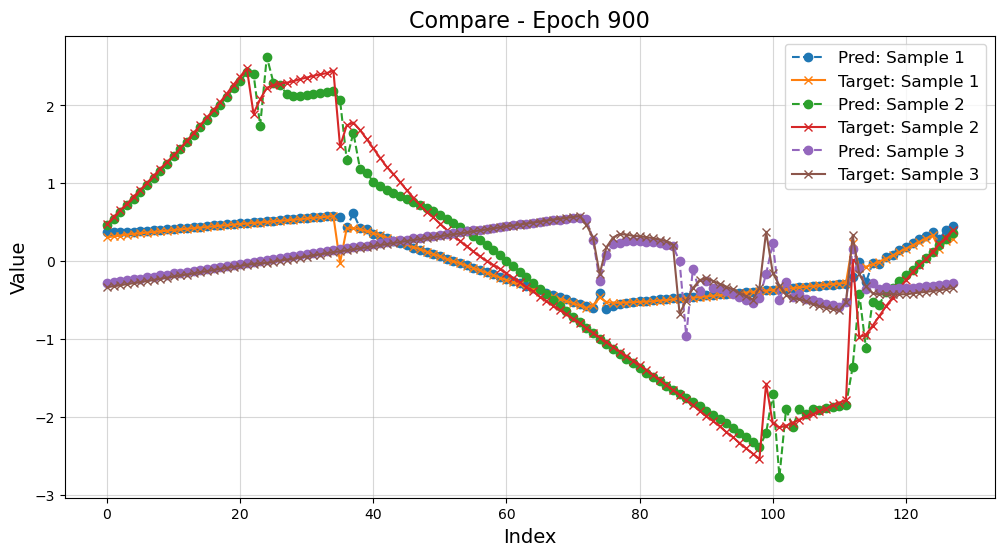

Epoch 901, Train Loss: 0.056496, Validation Loss: 0.070588
Epoch 902, Train Loss: 0.057400, Validation Loss: 0.070699
Epoch 903, Train Loss: 0.057105, Validation Loss: 0.070141
Epoch 904, Train Loss: 0.057867, Validation Loss: 0.070453
Epoch 905, Train Loss: 0.058226, Validation Loss: 0.070410
Epoch 906, Train Loss: 0.058808, Validation Loss: 0.070150
Epoch 907, Train Loss: 0.060831, Validation Loss: 0.069899
Saving model at epoch 907 with validation loss 0.069899...
Epoch 908, Train Loss: 0.057795, Validation Loss: 0.069885
Saving model at epoch 908 with validation loss 0.069885...
Epoch 909, Train Loss: 0.059840, Validation Loss: 0.071088
Epoch 910, Train Loss: 0.057338, Validation Loss: 0.073342
Epoch 911, Train Loss: 0.058260, Validation Loss: 0.071875
Epoch 912, Train Loss: 0.057340, Validation Loss: 0.071243
Epoch 913, Train Loss: 0.057495, Validation Loss: 0.071460
Epoch 914, Train Loss: 0.057291, Validation Loss: 0.070218
Epoch 915, Train Loss: 0.057289, Validation Loss: 0.0698

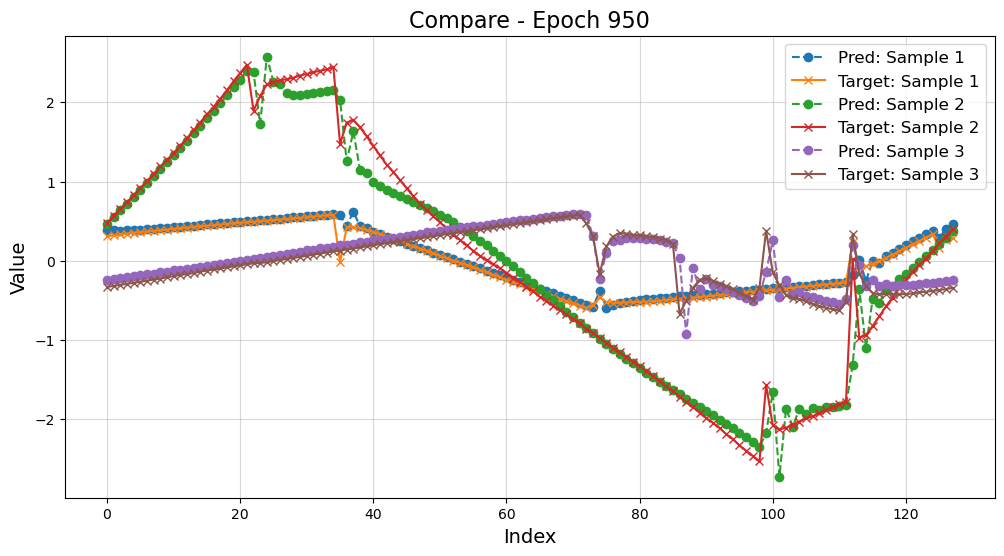

Epoch 951, Train Loss: 0.056152, Validation Loss: 0.070689
Epoch 952, Train Loss: 0.056894, Validation Loss: 0.069492
Epoch 953, Train Loss: 0.056491, Validation Loss: 0.070084
Epoch 954, Train Loss: 0.055320, Validation Loss: 0.070372
Epoch 955, Train Loss: 0.057811, Validation Loss: 0.069494
Epoch 956, Train Loss: 0.059305, Validation Loss: 0.069699
Epoch 957, Train Loss: 0.056608, Validation Loss: 0.069611
Epoch 958, Train Loss: 0.055451, Validation Loss: 0.069229
Saving model at epoch 958 with validation loss 0.069229...
Epoch 959, Train Loss: 0.057391, Validation Loss: 0.069929
Epoch 960, Train Loss: 0.056664, Validation Loss: 0.073698
Epoch 961, Train Loss: 0.059573, Validation Loss: 0.075057
Epoch 962, Train Loss: 0.059480, Validation Loss: 0.069377
Epoch 963, Train Loss: 0.055734, Validation Loss: 0.069091
Saving model at epoch 963 with validation loss 0.069091...
Epoch 964, Train Loss: 0.055358, Validation Loss: 0.069797
Epoch 965, Train Loss: 0.055573, Validation Loss: 0.0692

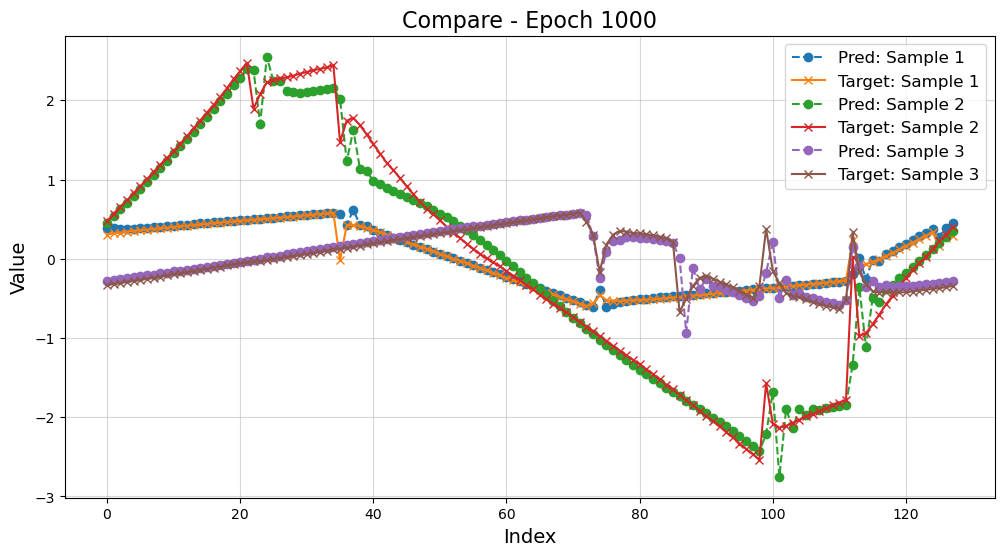

Epoch 1001, Train Loss: 0.056691, Validation Loss: 0.068793
Epoch 1002, Train Loss: 0.055655, Validation Loss: 0.070592
Epoch 1003, Train Loss: 0.056758, Validation Loss: 0.071407
Epoch 1004, Train Loss: 0.056369, Validation Loss: 0.069395
Epoch 1005, Train Loss: 0.056575, Validation Loss: 0.068844
Epoch 1006, Train Loss: 0.056052, Validation Loss: 0.069430
Epoch 1007, Train Loss: 0.055946, Validation Loss: 0.069723
Epoch 1008, Train Loss: 0.056474, Validation Loss: 0.068665
Saving model at epoch 1008 with validation loss 0.068665...
Epoch 1009, Train Loss: 0.059024, Validation Loss: 0.069175
Epoch 1010, Train Loss: 0.055797, Validation Loss: 0.070372
Epoch 1011, Train Loss: 0.055616, Validation Loss: 0.069518
Epoch 1012, Train Loss: 0.055211, Validation Loss: 0.069075
Epoch 1013, Train Loss: 0.056787, Validation Loss: 0.072599
Epoch 1014, Train Loss: 0.057546, Validation Loss: 0.068495
Saving model at epoch 1014 with validation loss 0.068495...
Epoch 1015, Train Loss: 0.055670, Valida

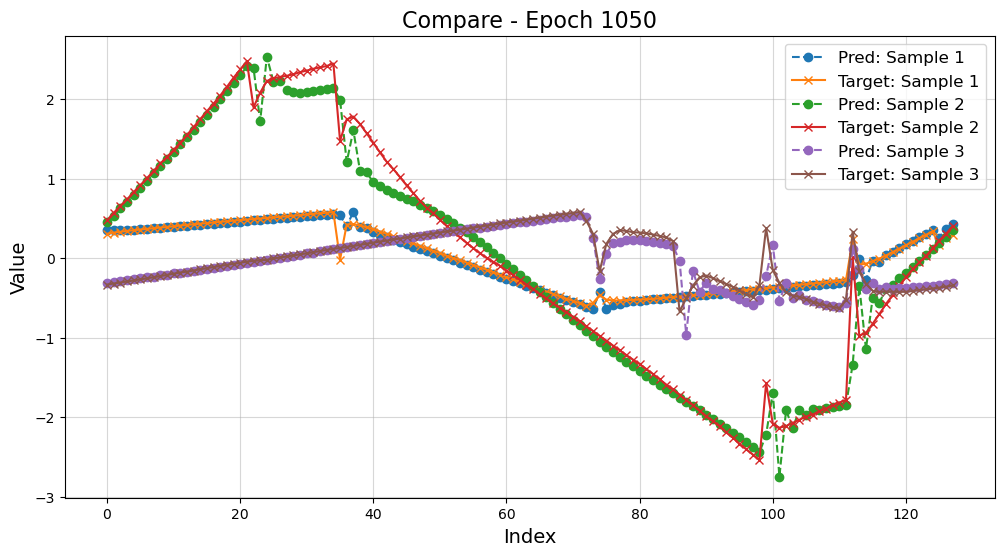

Epoch 1051, Train Loss: 0.054835, Validation Loss: 0.068870
Epoch 1052, Train Loss: 0.057545, Validation Loss: 0.068689
Epoch 1053, Train Loss: 0.055899, Validation Loss: 0.069175
Epoch 1054, Train Loss: 0.054310, Validation Loss: 0.067909
Saving model at epoch 1054 with validation loss 0.067909...
Epoch 1055, Train Loss: 0.055514, Validation Loss: 0.068210
Epoch 1056, Train Loss: 0.057740, Validation Loss: 0.068591
Epoch 1057, Train Loss: 0.055125, Validation Loss: 0.068128
Epoch 1058, Train Loss: 0.055354, Validation Loss: 0.068563
Epoch 1059, Train Loss: 0.055722, Validation Loss: 0.068601
Epoch 1060, Train Loss: 0.055613, Validation Loss: 0.068644
Epoch 1061, Train Loss: 0.055142, Validation Loss: 0.069107
Epoch 1062, Train Loss: 0.056124, Validation Loss: 0.068847
Epoch 1063, Train Loss: 0.054093, Validation Loss: 0.068458
Epoch 1064, Train Loss: 0.055103, Validation Loss: 0.068683
Epoch 1065, Train Loss: 0.055544, Validation Loss: 0.071418
Epoch 1066, Train Loss: 0.054961, Valida

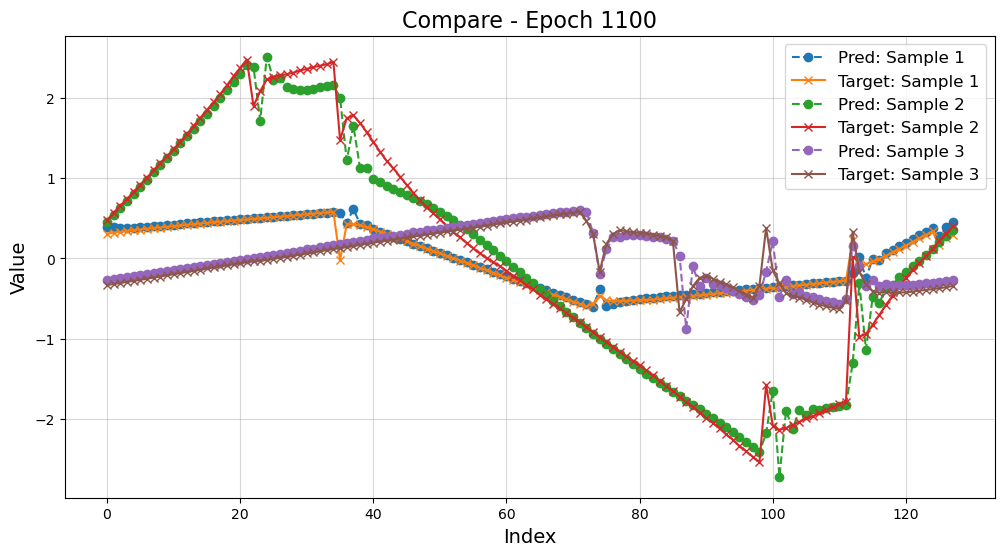

Saving model at epoch 1100 with validation loss 0.067670...
Epoch 1101, Train Loss: 0.053849, Validation Loss: 0.068199
Epoch 1102, Train Loss: 0.054424, Validation Loss: 0.068003
Epoch 1103, Train Loss: 0.055466, Validation Loss: 0.067612
Saving model at epoch 1103 with validation loss 0.067612...
Epoch 1104, Train Loss: 0.054048, Validation Loss: 0.068993
Epoch 1105, Train Loss: 0.058874, Validation Loss: 0.070042
Epoch 1106, Train Loss: 0.055417, Validation Loss: 0.069464
Epoch 1107, Train Loss: 0.054608, Validation Loss: 0.068517
Epoch 1108, Train Loss: 0.054785, Validation Loss: 0.068000
Epoch 1109, Train Loss: 0.054451, Validation Loss: 0.068039
Epoch 1110, Train Loss: 0.053833, Validation Loss: 0.068478
Epoch 1111, Train Loss: 0.055484, Validation Loss: 0.067577
Saving model at epoch 1111 with validation loss 0.067577...
Epoch 1112, Train Loss: 0.053348, Validation Loss: 0.068156
Epoch 1113, Train Loss: 0.055592, Validation Loss: 0.069934
Epoch 1114, Train Loss: 0.055147, Valida

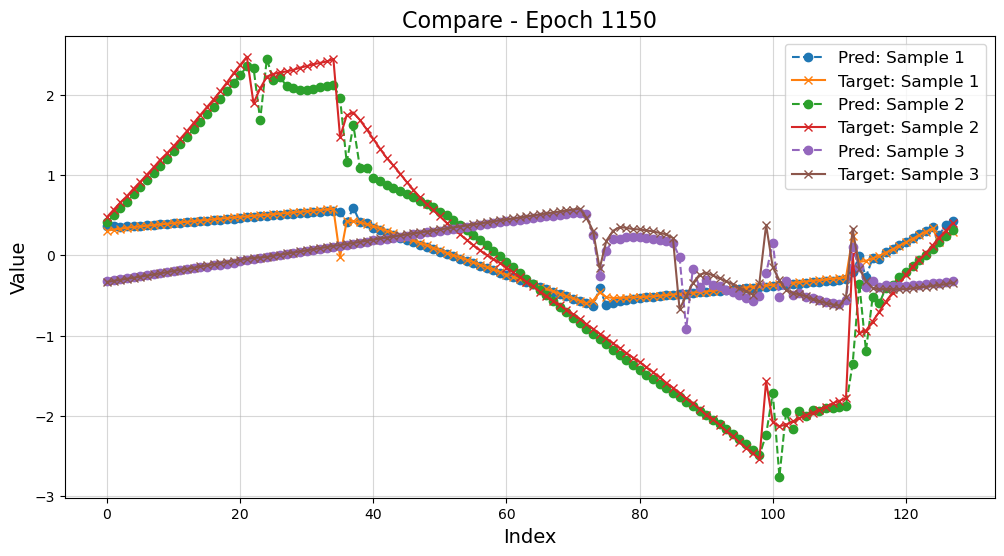

Epoch 1151, Train Loss: 0.056077, Validation Loss: 0.070855
Epoch 1152, Train Loss: 0.055297, Validation Loss: 0.068491
Epoch 1153, Train Loss: 0.054173, Validation Loss: 0.067566
Epoch 1154, Train Loss: 0.053440, Validation Loss: 0.067307
Epoch 1155, Train Loss: 0.054585, Validation Loss: 0.067987
Epoch 1156, Train Loss: 0.054232, Validation Loss: 0.067598
Epoch 1157, Train Loss: 0.054004, Validation Loss: 0.067423
Epoch 1158, Train Loss: 0.054408, Validation Loss: 0.067216
Saving model at epoch 1158 with validation loss 0.067216...
Epoch 1159, Train Loss: 0.054659, Validation Loss: 0.069401
Epoch 1160, Train Loss: 0.054159, Validation Loss: 0.067866
Epoch 1161, Train Loss: 0.054032, Validation Loss: 0.068989
Epoch 1162, Train Loss: 0.053427, Validation Loss: 0.067944
Epoch 1163, Train Loss: 0.053214, Validation Loss: 0.067373
Epoch 1164, Train Loss: 0.052610, Validation Loss: 0.068251
Epoch 1165, Train Loss: 0.053732, Validation Loss: 0.067895
Epoch 1166, Train Loss: 0.052945, Valida

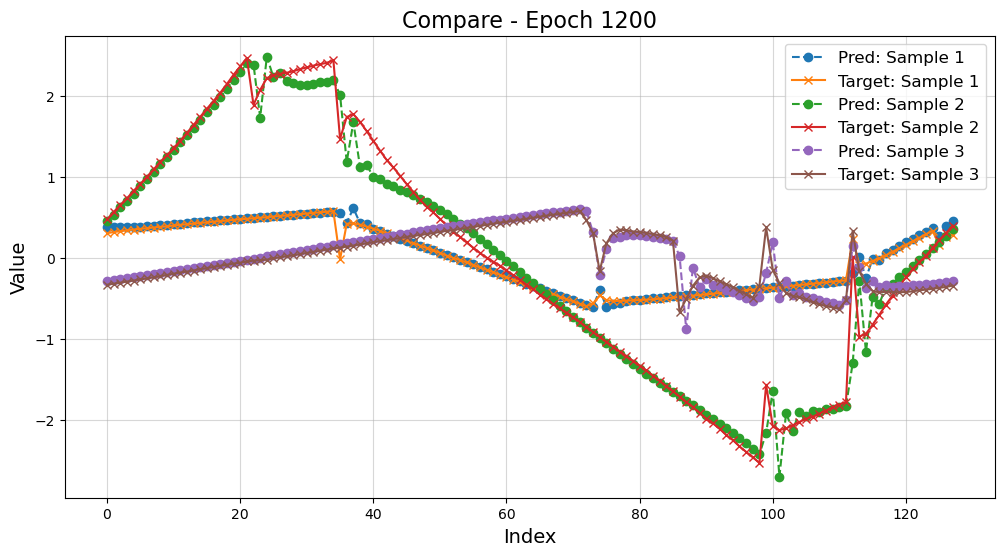

Epoch 1201, Train Loss: 0.052290, Validation Loss: 0.066964
Epoch 1202, Train Loss: 0.052525, Validation Loss: 0.068382
Epoch 1203, Train Loss: 0.052365, Validation Loss: 0.067548
Epoch 1204, Train Loss: 0.052251, Validation Loss: 0.066854
Saving model at epoch 1204 with validation loss 0.066854...
Epoch 1205, Train Loss: 0.054719, Validation Loss: 0.068143
Epoch 1206, Train Loss: 0.053984, Validation Loss: 0.069011
Epoch 1207, Train Loss: 0.053974, Validation Loss: 0.067751
Epoch 1208, Train Loss: 0.052859, Validation Loss: 0.068320
Epoch 1209, Train Loss: 0.052046, Validation Loss: 0.067420
Epoch 1210, Train Loss: 0.052968, Validation Loss: 0.067448
Epoch 1211, Train Loss: 0.053060, Validation Loss: 0.068337
Epoch 1212, Train Loss: 0.052221, Validation Loss: 0.067765
Epoch 1213, Train Loss: 0.053378, Validation Loss: 0.066794
Saving model at epoch 1213 with validation loss 0.066794...
Epoch 1214, Train Loss: 0.052116, Validation Loss: 0.066902
Epoch 1215, Train Loss: 0.052914, Valida

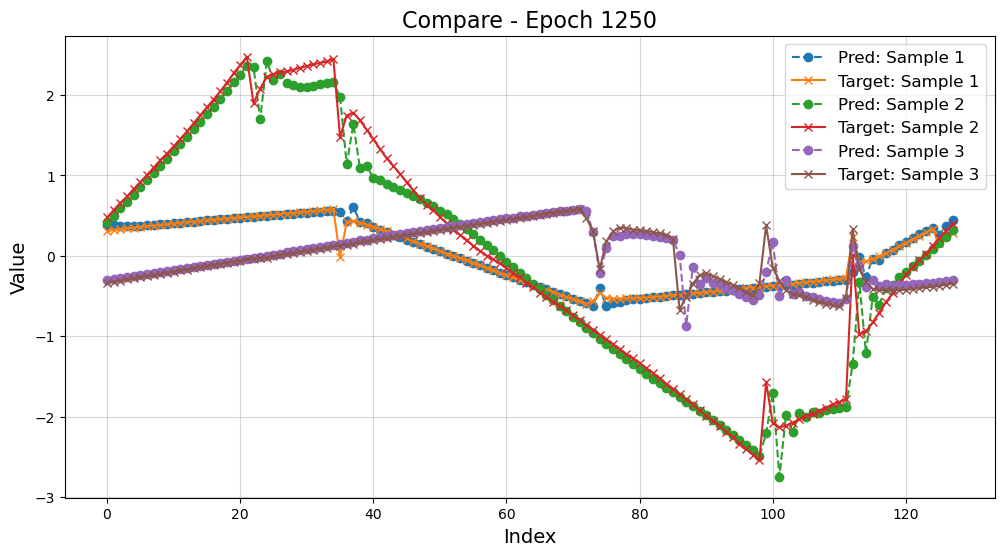

Epoch 1251, Train Loss: 0.051850, Validation Loss: 0.067028
Epoch 1252, Train Loss: 0.051498, Validation Loss: 0.068016
Epoch 1253, Train Loss: 0.052624, Validation Loss: 0.066609
Epoch 1254, Train Loss: 0.051822, Validation Loss: 0.066851
Epoch 1255, Train Loss: 0.053042, Validation Loss: 0.067641
Epoch 1256, Train Loss: 0.052099, Validation Loss: 0.066428
Epoch 1257, Train Loss: 0.050953, Validation Loss: 0.066809
Epoch 1258, Train Loss: 0.055061, Validation Loss: 0.066440
Epoch 1259, Train Loss: 0.052129, Validation Loss: 0.066620
Epoch 1260, Train Loss: 0.051314, Validation Loss: 0.065974
Saving model at epoch 1260 with validation loss 0.065974...
Epoch 1261, Train Loss: 0.052764, Validation Loss: 0.067102
Epoch 1262, Train Loss: 0.052030, Validation Loss: 0.066709
Epoch 1263, Train Loss: 0.052061, Validation Loss: 0.066641
Epoch 1264, Train Loss: 0.051637, Validation Loss: 0.066500
Epoch 1265, Train Loss: 0.053256, Validation Loss: 0.066105
Epoch 1266, Train Loss: 0.052143, Valida

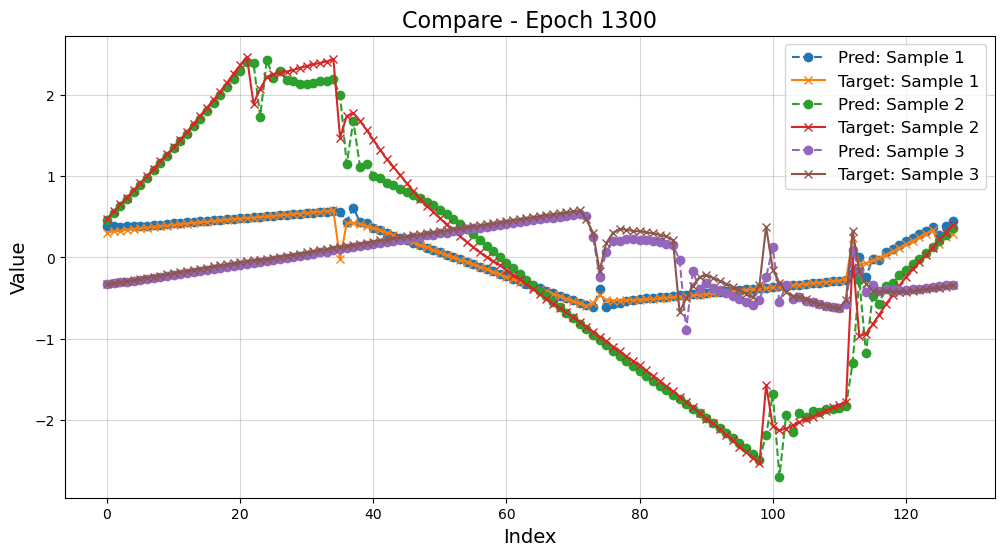

Epoch 1301, Train Loss: 0.053376, Validation Loss: 0.066154
Epoch 1302, Train Loss: 0.051042, Validation Loss: 0.065906
Epoch 1303, Train Loss: 0.050844, Validation Loss: 0.066292
Epoch 1304, Train Loss: 0.051736, Validation Loss: 0.065954
Epoch 1305, Train Loss: 0.051404, Validation Loss: 0.066285
Epoch 1306, Train Loss: 0.053364, Validation Loss: 0.066020
Epoch 1307, Train Loss: 0.051313, Validation Loss: 0.065601
Epoch 1308, Train Loss: 0.051232, Validation Loss: 0.066563
Epoch 1309, Train Loss: 0.051655, Validation Loss: 0.065998
Epoch 1310, Train Loss: 0.052808, Validation Loss: 0.067957
Epoch 1311, Train Loss: 0.051856, Validation Loss: 0.067203
Epoch 1312, Train Loss: 0.053147, Validation Loss: 0.066069
Epoch 1313, Train Loss: 0.051986, Validation Loss: 0.068099
Epoch 1314, Train Loss: 0.054815, Validation Loss: 0.074412
Epoch 1315, Train Loss: 0.055191, Validation Loss: 0.066350
Epoch 1316, Train Loss: 0.052678, Validation Loss: 0.066169
Epoch 1317, Train Loss: 0.051256, Valida

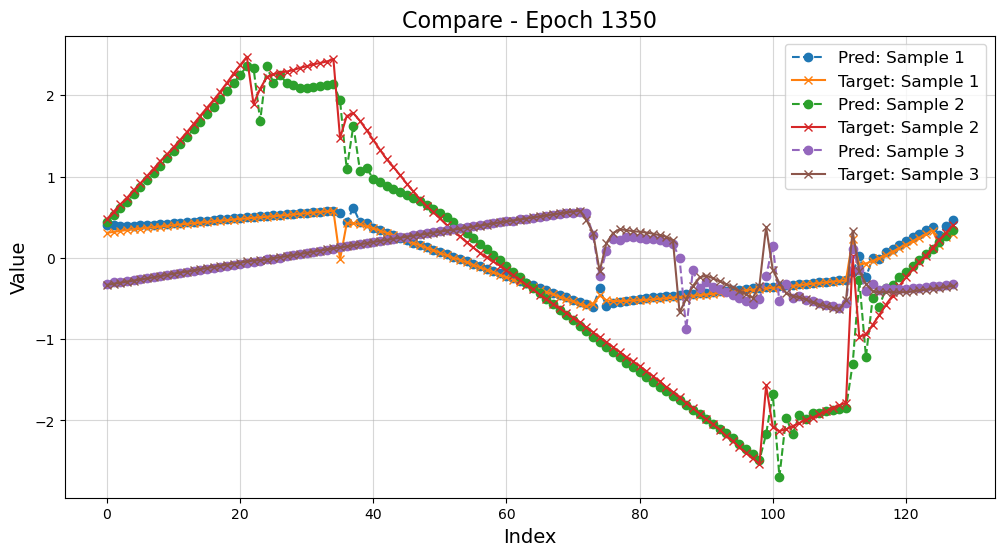

Epoch 1351, Train Loss: 0.050915, Validation Loss: 0.065502
Epoch 1352, Train Loss: 0.051183, Validation Loss: 0.067783
Epoch 1353, Train Loss: 0.051376, Validation Loss: 0.067392
Epoch 1354, Train Loss: 0.051765, Validation Loss: 0.066246
Epoch 1355, Train Loss: 0.051175, Validation Loss: 0.065681
Epoch 1356, Train Loss: 0.053882, Validation Loss: 0.065972
Epoch 1357, Train Loss: 0.050652, Validation Loss: 0.065495
Epoch 1358, Train Loss: 0.049703, Validation Loss: 0.065402
Epoch 1359, Train Loss: 0.050144, Validation Loss: 0.066934
Epoch 1360, Train Loss: 0.051251, Validation Loss: 0.066400
Epoch 1361, Train Loss: 0.052410, Validation Loss: 0.066526
Epoch 1362, Train Loss: 0.050283, Validation Loss: 0.065965
Epoch 1363, Train Loss: 0.050509, Validation Loss: 0.065204
Saving model at epoch 1363 with validation loss 0.065204...
Epoch 1364, Train Loss: 0.050557, Validation Loss: 0.066147
Epoch 1365, Train Loss: 0.050052, Validation Loss: 0.065566
Epoch 1366, Train Loss: 0.051979, Valida

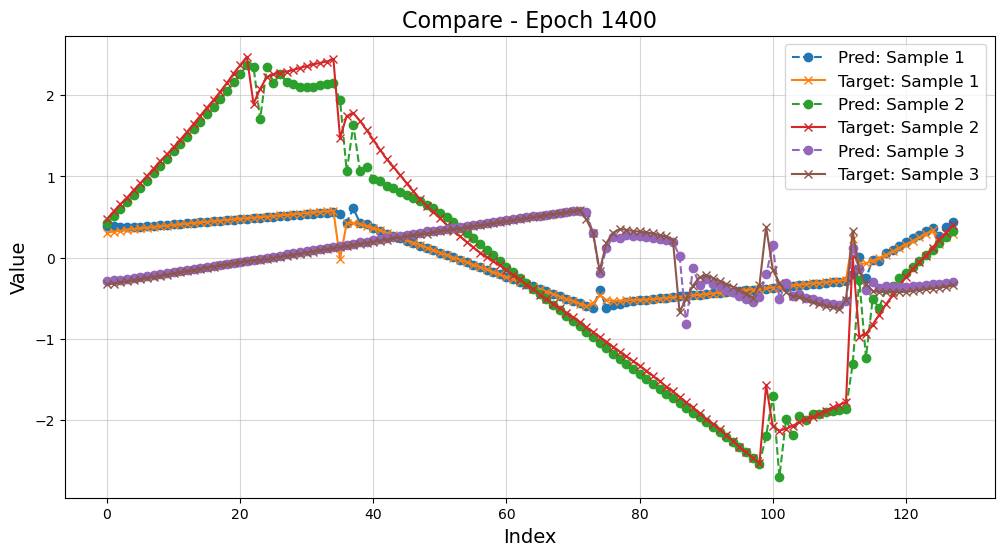

Epoch 1401, Train Loss: 0.049724, Validation Loss: 0.066266
Epoch 1402, Train Loss: 0.049508, Validation Loss: 0.065019
Epoch 1403, Train Loss: 0.049592, Validation Loss: 0.064853
Epoch 1404, Train Loss: 0.049851, Validation Loss: 0.064955
Epoch 1405, Train Loss: 0.049262, Validation Loss: 0.065536
Epoch 1406, Train Loss: 0.050934, Validation Loss: 0.066773
Epoch 1407, Train Loss: 0.049942, Validation Loss: 0.064765
Epoch 1408, Train Loss: 0.051441, Validation Loss: 0.064625
Saving model at epoch 1408 with validation loss 0.064625...
Epoch 1409, Train Loss: 0.049626, Validation Loss: 0.064721
Epoch 1410, Train Loss: 0.050968, Validation Loss: 0.064867
Epoch 1411, Train Loss: 0.049562, Validation Loss: 0.065273
Epoch 1412, Train Loss: 0.051623, Validation Loss: 0.065154
Epoch 1413, Train Loss: 0.050612, Validation Loss: 0.064924
Epoch 1414, Train Loss: 0.050438, Validation Loss: 0.065501
Epoch 1415, Train Loss: 0.050945, Validation Loss: 0.065248
Epoch 1416, Train Loss: 0.050777, Valida

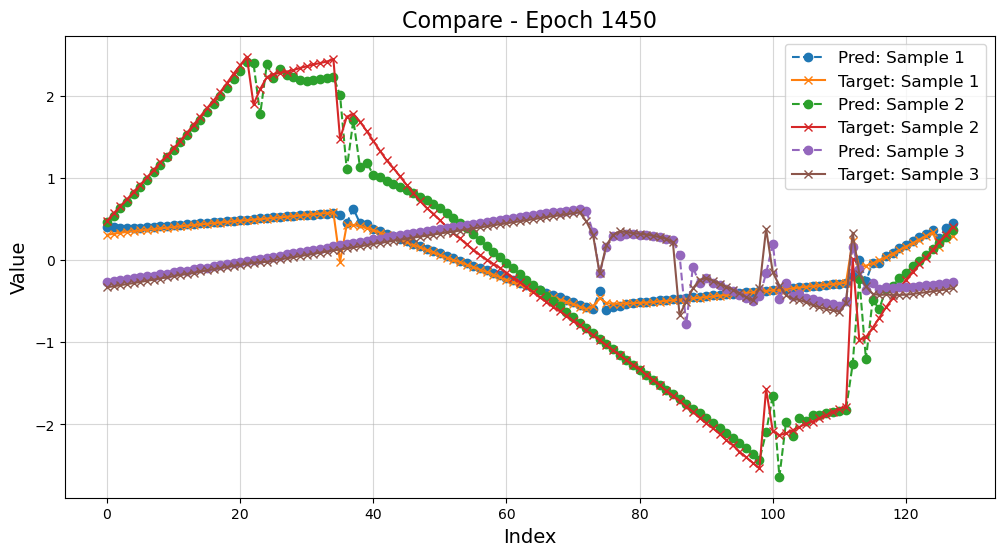

Epoch 1451, Train Loss: 0.050035, Validation Loss: 0.064689
Epoch 1452, Train Loss: 0.050766, Validation Loss: 0.064260
Saving model at epoch 1452 with validation loss 0.064260...
Epoch 1453, Train Loss: 0.050633, Validation Loss: 0.066865
Epoch 1454, Train Loss: 0.050173, Validation Loss: 0.065539
Epoch 1455, Train Loss: 0.049868, Validation Loss: 0.064697
Epoch 1456, Train Loss: 0.050171, Validation Loss: 0.064907
Epoch 1457, Train Loss: 0.049899, Validation Loss: 0.065840
Epoch 1458, Train Loss: 0.051124, Validation Loss: 0.064348
Epoch 1459, Train Loss: 0.050581, Validation Loss: 0.068907
Epoch 1460, Train Loss: 0.050880, Validation Loss: 0.065270
Epoch 1461, Train Loss: 0.051656, Validation Loss: 0.064690
Epoch 1462, Train Loss: 0.052645, Validation Loss: 0.067236
Epoch 1463, Train Loss: 0.050186, Validation Loss: 0.064774
Epoch 1464, Train Loss: 0.050194, Validation Loss: 0.065022
Epoch 1465, Train Loss: 0.051951, Validation Loss: 0.065496
Epoch 1466, Train Loss: 0.050926, Valida

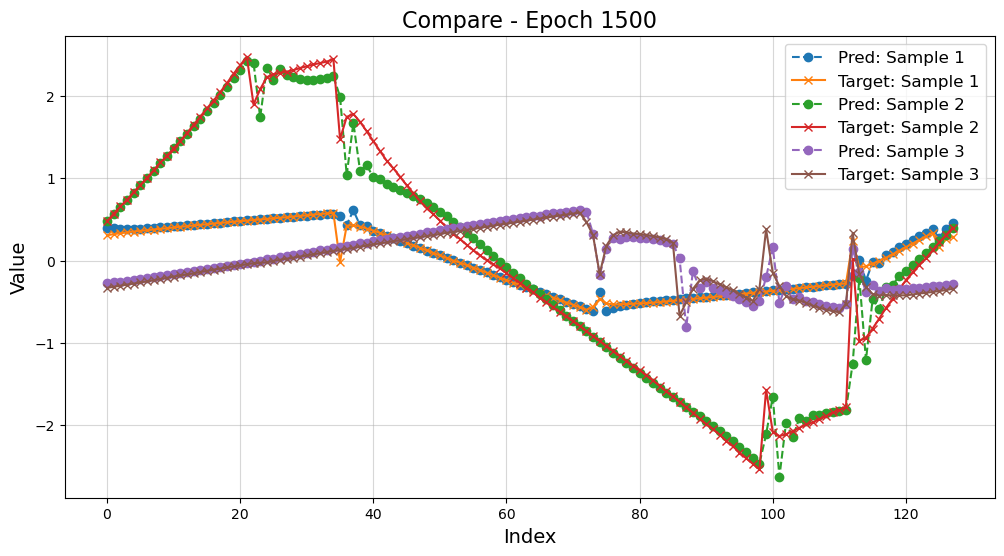

Epoch 1501, Train Loss: 0.049508, Validation Loss: 0.065221
Epoch 1502, Train Loss: 0.050592, Validation Loss: 0.063953
Epoch 1503, Train Loss: 0.050484, Validation Loss: 0.064214
Epoch 1504, Train Loss: 0.049390, Validation Loss: 0.065325
Epoch 1505, Train Loss: 0.051665, Validation Loss: 0.064853
Epoch 1506, Train Loss: 0.050810, Validation Loss: 0.064576
Epoch 1507, Train Loss: 0.051377, Validation Loss: 0.065500
Epoch 1508, Train Loss: 0.049026, Validation Loss: 0.065110
Epoch 1509, Train Loss: 0.049297, Validation Loss: 0.064536
Epoch 1510, Train Loss: 0.048466, Validation Loss: 0.064404
Epoch 1511, Train Loss: 0.048983, Validation Loss: 0.063587
Saving model at epoch 1511 with validation loss 0.063587...
Epoch 1512, Train Loss: 0.047912, Validation Loss: 0.063913
Epoch 1513, Train Loss: 0.049475, Validation Loss: 0.063814
Epoch 1514, Train Loss: 0.049794, Validation Loss: 0.065307
Epoch 1515, Train Loss: 0.049085, Validation Loss: 0.063562
Saving model at epoch 1515 with validati

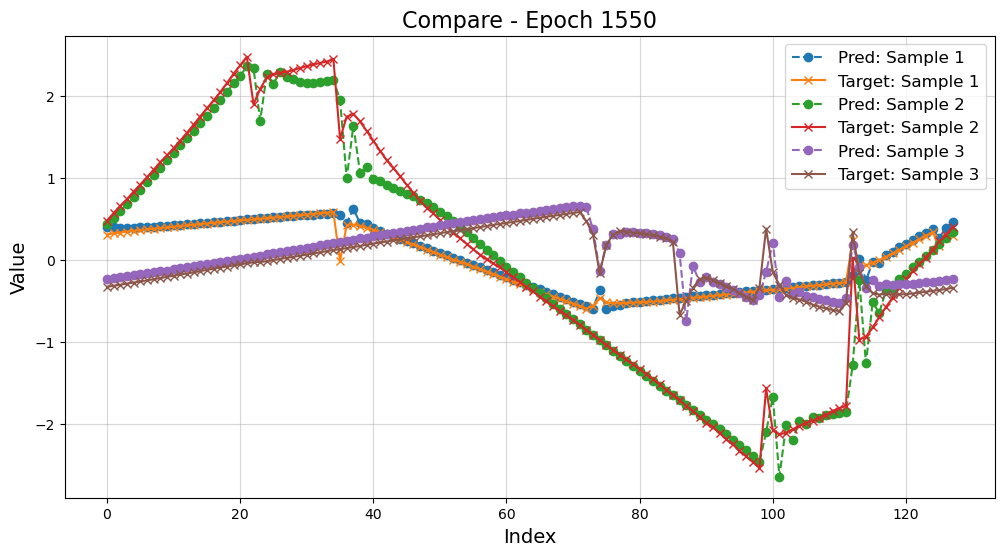

Epoch 1551, Train Loss: 0.048878, Validation Loss: 0.063789
Epoch 1552, Train Loss: 0.049577, Validation Loss: 0.063721
Epoch 1553, Train Loss: 0.049066, Validation Loss: 0.063824
Epoch 1554, Train Loss: 0.049238, Validation Loss: 0.063221
Saving model at epoch 1554 with validation loss 0.063221...
Epoch 1555, Train Loss: 0.048245, Validation Loss: 0.063420
Epoch 1556, Train Loss: 0.051921, Validation Loss: 0.064220
Epoch 1557, Train Loss: 0.051040, Validation Loss: 0.064105
Epoch 1558, Train Loss: 0.050066, Validation Loss: 0.064417
Epoch 1559, Train Loss: 0.049073, Validation Loss: 0.063475
Epoch 1560, Train Loss: 0.048719, Validation Loss: 0.065153
Epoch 1561, Train Loss: 0.048729, Validation Loss: 0.063401
Epoch 1562, Train Loss: 0.047941, Validation Loss: 0.063682
Epoch 1563, Train Loss: 0.048889, Validation Loss: 0.063439
Epoch 1564, Train Loss: 0.048841, Validation Loss: 0.063484
Epoch 1565, Train Loss: 0.047715, Validation Loss: 0.063548
Epoch 1566, Train Loss: 0.048408, Valida

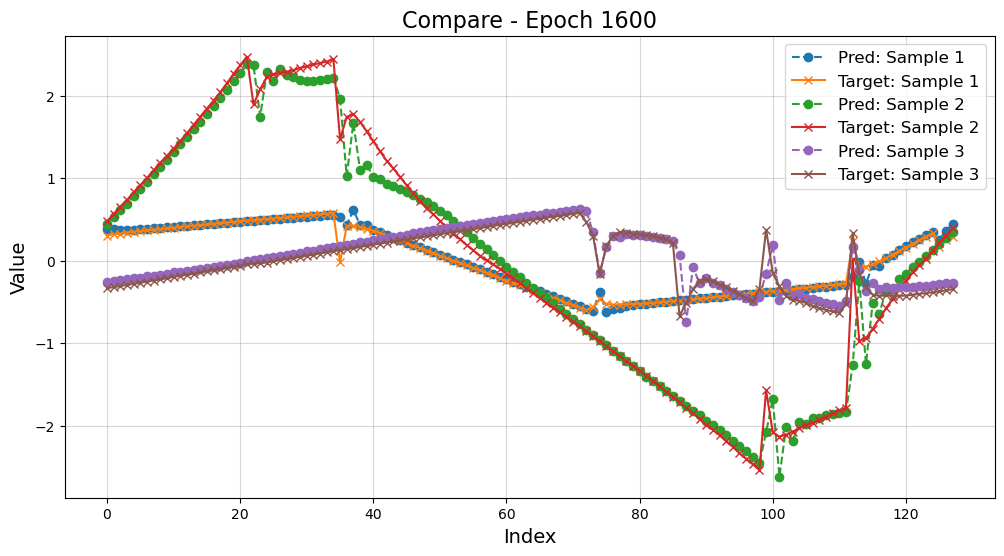

Epoch 1601, Train Loss: 0.049428, Validation Loss: 0.062768
Epoch 1602, Train Loss: 0.047891, Validation Loss: 0.063041
Epoch 1603, Train Loss: 0.047966, Validation Loss: 0.065630
Epoch 1604, Train Loss: 0.048427, Validation Loss: 0.063041
Epoch 1605, Train Loss: 0.048382, Validation Loss: 0.068527
Epoch 1606, Train Loss: 0.050381, Validation Loss: 0.065553
Epoch 1607, Train Loss: 0.049399, Validation Loss: 0.062801
Epoch 1608, Train Loss: 0.048346, Validation Loss: 0.063399
Epoch 1609, Train Loss: 0.047742, Validation Loss: 0.063386
Epoch 1610, Train Loss: 0.048446, Validation Loss: 0.062979
Epoch 1611, Train Loss: 0.048850, Validation Loss: 0.063548
Epoch 1612, Train Loss: 0.048529, Validation Loss: 0.063741
Epoch 1613, Train Loss: 0.048940, Validation Loss: 0.062668
Saving model at epoch 1613 with validation loss 0.062668...
Epoch 1614, Train Loss: 0.047216, Validation Loss: 0.062757
Epoch 1615, Train Loss: 0.049366, Validation Loss: 0.062941
Epoch 1616, Train Loss: 0.049205, Valida

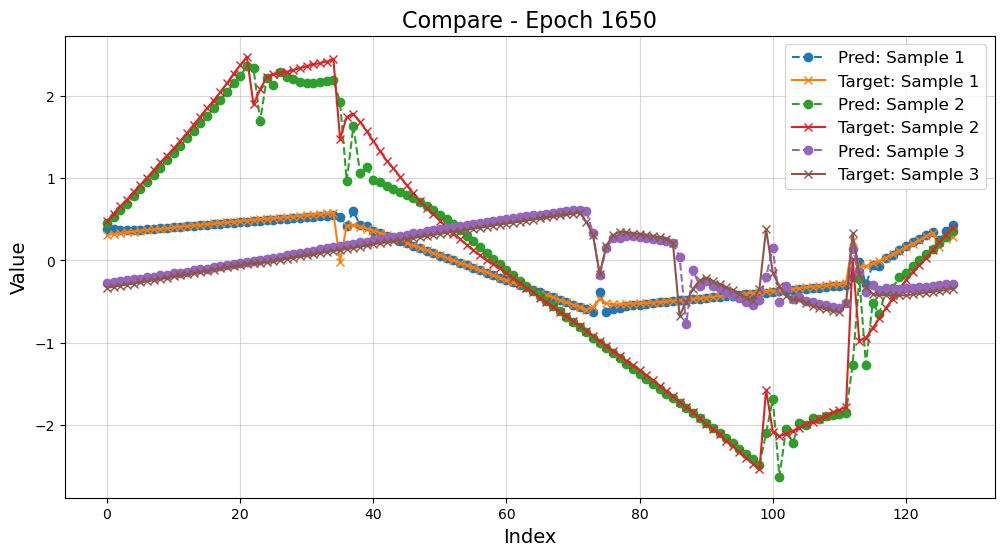

Epoch 1651, Train Loss: 0.047293, Validation Loss: 0.063476
Epoch 1652, Train Loss: 0.048606, Validation Loss: 0.063648
Epoch 1653, Train Loss: 0.046785, Validation Loss: 0.062271
Epoch 1654, Train Loss: 0.047675, Validation Loss: 0.062224
Epoch 1655, Train Loss: 0.047518, Validation Loss: 0.062663
Epoch 1656, Train Loss: 0.046648, Validation Loss: 0.062412
Epoch 1657, Train Loss: 0.048834, Validation Loss: 0.062656
Epoch 1658, Train Loss: 0.048530, Validation Loss: 0.062371
Epoch 1659, Train Loss: 0.048076, Validation Loss: 0.062267
Epoch 1660, Train Loss: 0.046692, Validation Loss: 0.062427
Epoch 1661, Train Loss: 0.046001, Validation Loss: 0.063116
Epoch 1662, Train Loss: 0.047126, Validation Loss: 0.062517
Epoch 1663, Train Loss: 0.047547, Validation Loss: 0.062761
Epoch 1664, Train Loss: 0.050277, Validation Loss: 0.062535
Epoch 1665, Train Loss: 0.047983, Validation Loss: 0.062506
Epoch 1666, Train Loss: 0.046072, Validation Loss: 0.062360
Epoch 1667, Train Loss: 0.047504, Valida

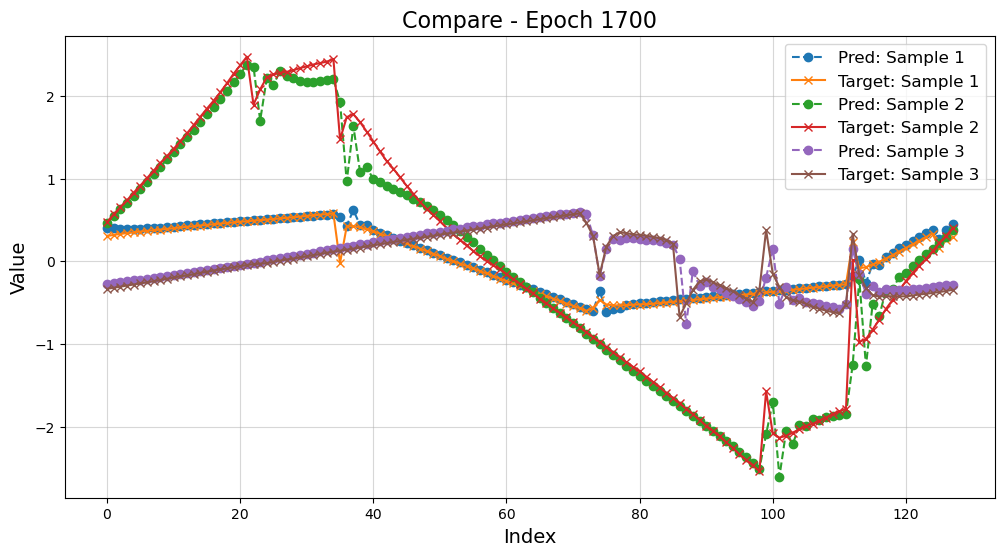

Epoch 1701, Train Loss: 0.046079, Validation Loss: 0.062646
Epoch 1702, Train Loss: 0.046364, Validation Loss: 0.062915
Epoch 1703, Train Loss: 0.047552, Validation Loss: 0.062127
Epoch 1704, Train Loss: 0.047549, Validation Loss: 0.062144
Epoch 1705, Train Loss: 0.047199, Validation Loss: 0.061723
Epoch 1706, Train Loss: 0.045917, Validation Loss: 0.061975
Epoch 1707, Train Loss: 0.047016, Validation Loss: 0.061698
Epoch 1708, Train Loss: 0.047729, Validation Loss: 0.063176
Epoch 1709, Train Loss: 0.047526, Validation Loss: 0.062097
Epoch 1710, Train Loss: 0.048433, Validation Loss: 0.062352
Epoch 1711, Train Loss: 0.048444, Validation Loss: 0.065785
Epoch 1712, Train Loss: 0.047581, Validation Loss: 0.062261
Epoch 1713, Train Loss: 0.047310, Validation Loss: 0.063746
Epoch 1714, Train Loss: 0.048883, Validation Loss: 0.065038
Epoch 1715, Train Loss: 0.047580, Validation Loss: 0.062993
Epoch 1716, Train Loss: 0.047801, Validation Loss: 0.063013
Epoch 1717, Train Loss: 0.047860, Valida

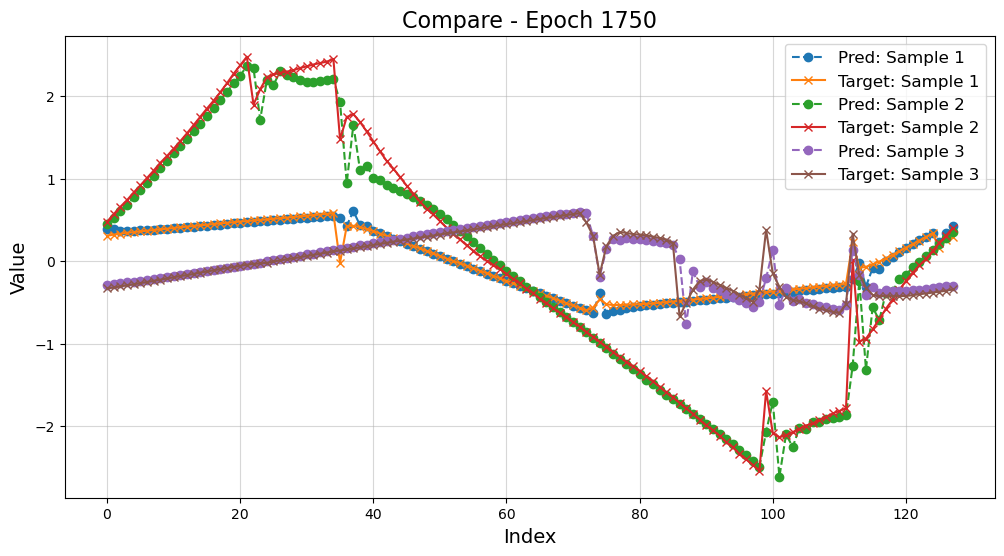

Epoch 1751, Train Loss: 0.046991, Validation Loss: 0.062090
Epoch 1752, Train Loss: 0.047355, Validation Loss: 0.061456
Saving model at epoch 1752 with validation loss 0.061456...
Epoch 1753, Train Loss: 0.047872, Validation Loss: 0.062126
Epoch 1754, Train Loss: 0.047136, Validation Loss: 0.061654
Epoch 1755, Train Loss: 0.046246, Validation Loss: 0.062345
Epoch 1756, Train Loss: 0.046769, Validation Loss: 0.061084
Saving model at epoch 1756 with validation loss 0.061084...
Epoch 1757, Train Loss: 0.045960, Validation Loss: 0.062058
Epoch 1758, Train Loss: 0.047861, Validation Loss: 0.062323
Epoch 1759, Train Loss: 0.046189, Validation Loss: 0.061739
Epoch 1760, Train Loss: 0.047623, Validation Loss: 0.061450
Epoch 1761, Train Loss: 0.046564, Validation Loss: 0.062849
Epoch 1762, Train Loss: 0.047496, Validation Loss: 0.061891
Epoch 1763, Train Loss: 0.046752, Validation Loss: 0.061921
Epoch 1764, Train Loss: 0.047989, Validation Loss: 0.061525
Epoch 1765, Train Loss: 0.045872, Valida

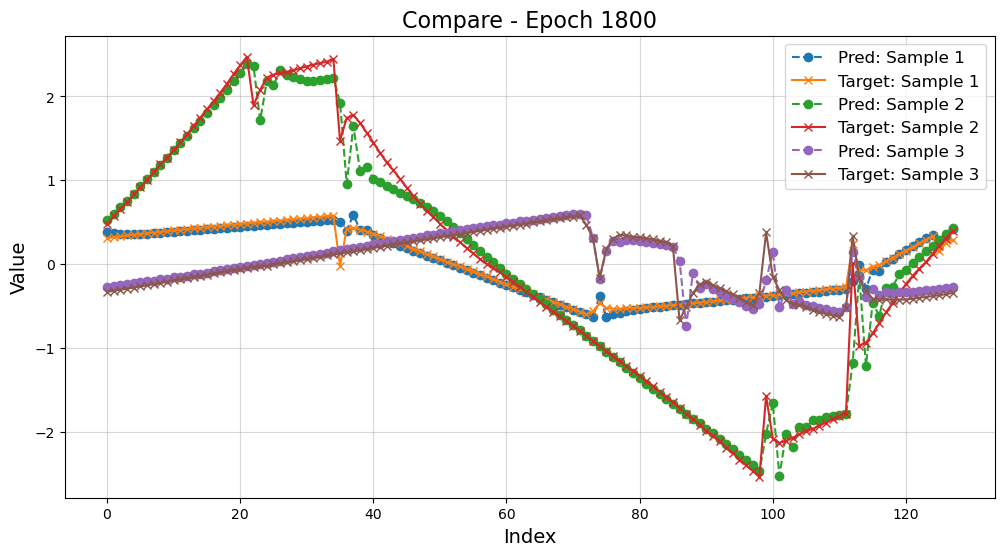

Saving model at epoch 1800 with validation loss 0.061081...
Epoch 1801, Train Loss: 0.046656, Validation Loss: 0.061200
Epoch 1802, Train Loss: 0.045794, Validation Loss: 0.061541
Epoch 1803, Train Loss: 0.045980, Validation Loss: 0.061566
Epoch 1804, Train Loss: 0.046550, Validation Loss: 0.061533
Epoch 1805, Train Loss: 0.045738, Validation Loss: 0.061187
Epoch 1806, Train Loss: 0.046675, Validation Loss: 0.060978
Saving model at epoch 1806 with validation loss 0.060978...
Epoch 1807, Train Loss: 0.047206, Validation Loss: 0.061251
Epoch 1808, Train Loss: 0.045680, Validation Loss: 0.061480
Epoch 1809, Train Loss: 0.045684, Validation Loss: 0.061139
Epoch 1810, Train Loss: 0.047617, Validation Loss: 0.061302
Epoch 1811, Train Loss: 0.046444, Validation Loss: 0.061460
Epoch 1812, Train Loss: 0.046997, Validation Loss: 0.061749
Epoch 1813, Train Loss: 0.045145, Validation Loss: 0.060818
Saving model at epoch 1813 with validation loss 0.060818...
Epoch 1814, Train Loss: 0.045818, Valida

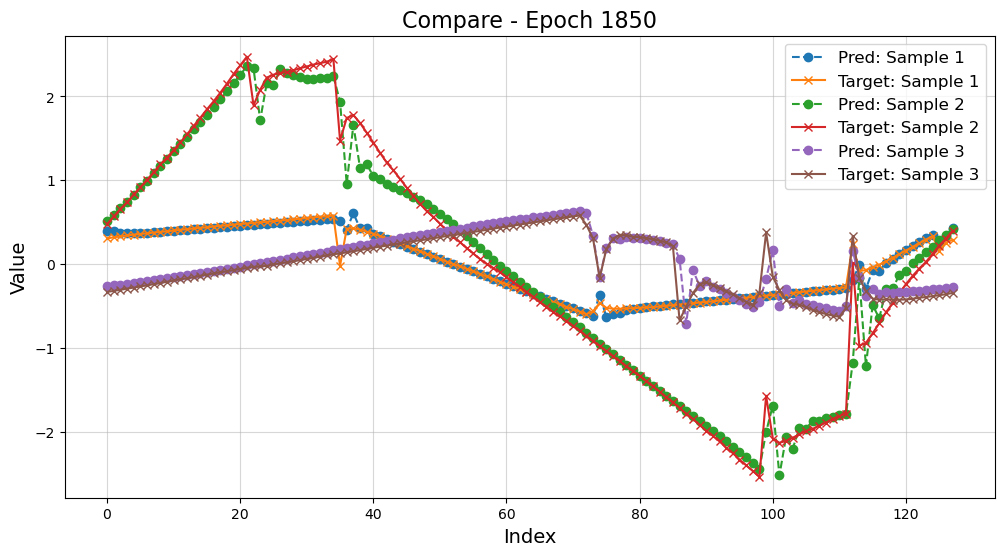

Epoch 1851, Train Loss: 0.045910, Validation Loss: 0.060844
Epoch 1852, Train Loss: 0.044751, Validation Loss: 0.060478
Epoch 1853, Train Loss: 0.045199, Validation Loss: 0.060617
Epoch 1854, Train Loss: 0.045886, Validation Loss: 0.061001
Epoch 1855, Train Loss: 0.046533, Validation Loss: 0.060486
Epoch 1856, Train Loss: 0.045351, Validation Loss: 0.060725
Epoch 1857, Train Loss: 0.045490, Validation Loss: 0.060417
Saving model at epoch 1857 with validation loss 0.060417...
Epoch 1858, Train Loss: 0.045921, Validation Loss: 0.060605
Epoch 1859, Train Loss: 0.046002, Validation Loss: 0.060653
Epoch 1860, Train Loss: 0.046227, Validation Loss: 0.060941
Epoch 1861, Train Loss: 0.045224, Validation Loss: 0.061424
Epoch 1862, Train Loss: 0.047435, Validation Loss: 0.061281
Epoch 1863, Train Loss: 0.045568, Validation Loss: 0.060630
Epoch 1864, Train Loss: 0.047584, Validation Loss: 0.060586
Epoch 1865, Train Loss: 0.044557, Validation Loss: 0.062888
Epoch 1866, Train Loss: 0.045825, Valida

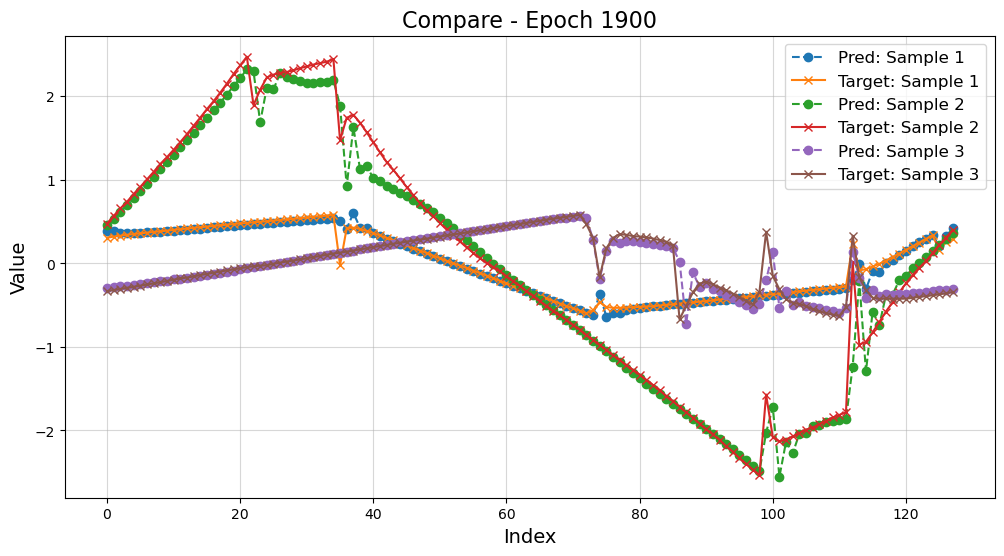

Epoch 1901, Train Loss: 0.044673, Validation Loss: 0.059895
Saving model at epoch 1901 with validation loss 0.059895...
Epoch 1902, Train Loss: 0.044837, Validation Loss: 0.060806
Epoch 1903, Train Loss: 0.045110, Validation Loss: 0.062119
Epoch 1904, Train Loss: 0.044361, Validation Loss: 0.060245
Epoch 1905, Train Loss: 0.044321, Validation Loss: 0.060552
Epoch 1906, Train Loss: 0.046293, Validation Loss: 0.061530
Epoch 1907, Train Loss: 0.046248, Validation Loss: 0.059898
Epoch 1908, Train Loss: 0.045258, Validation Loss: 0.060884
Epoch 1909, Train Loss: 0.045101, Validation Loss: 0.060095
Epoch 1910, Train Loss: 0.045418, Validation Loss: 0.061260
Epoch 1911, Train Loss: 0.045327, Validation Loss: 0.061199
Epoch 1912, Train Loss: 0.044445, Validation Loss: 0.060218
Epoch 1913, Train Loss: 0.044951, Validation Loss: 0.060090
Epoch 1914, Train Loss: 0.045567, Validation Loss: 0.060599
Epoch 1915, Train Loss: 0.044584, Validation Loss: 0.060480
Epoch 1916, Train Loss: 0.044327, Valida

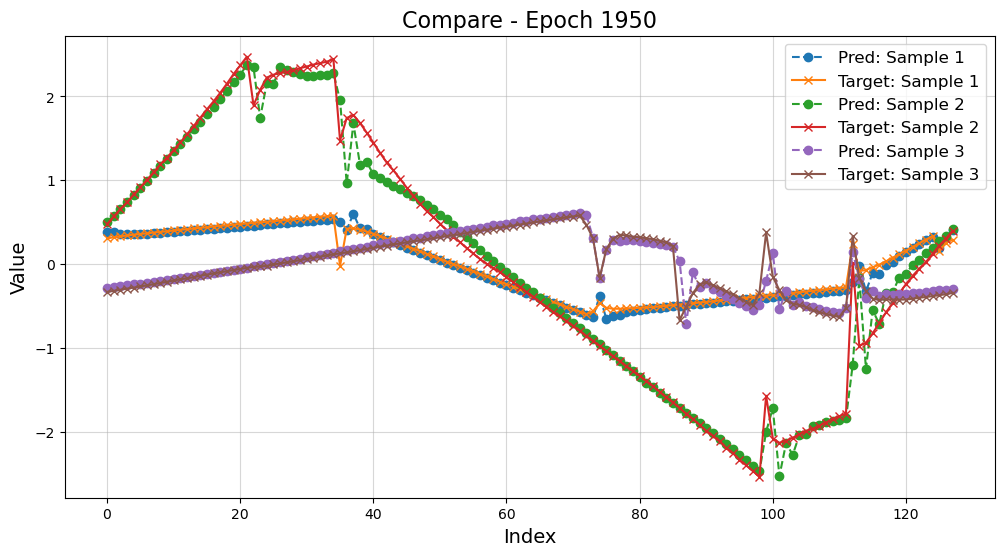

Epoch 1951, Train Loss: 0.045642, Validation Loss: 0.061039
Epoch 1952, Train Loss: 0.045575, Validation Loss: 0.059806
Epoch 1953, Train Loss: 0.044030, Validation Loss: 0.061587
Epoch 1954, Train Loss: 0.045478, Validation Loss: 0.060133
Epoch 1955, Train Loss: 0.044385, Validation Loss: 0.059527
Saving model at epoch 1955 with validation loss 0.059527...
Epoch 1956, Train Loss: 0.045979, Validation Loss: 0.061443
Epoch 1957, Train Loss: 0.044818, Validation Loss: 0.060200
Epoch 1958, Train Loss: 0.044852, Validation Loss: 0.060878
Epoch 1959, Train Loss: 0.043967, Validation Loss: 0.059946
Epoch 1960, Train Loss: 0.043771, Validation Loss: 0.060336
Epoch 1961, Train Loss: 0.047038, Validation Loss: 0.060080
Epoch 1962, Train Loss: 0.045367, Validation Loss: 0.059516
Saving model at epoch 1962 with validation loss 0.059516...
Epoch 1963, Train Loss: 0.043844, Validation Loss: 0.059523
Epoch 1964, Train Loss: 0.045871, Validation Loss: 0.059932
Epoch 1965, Train Loss: 0.043099, Valida

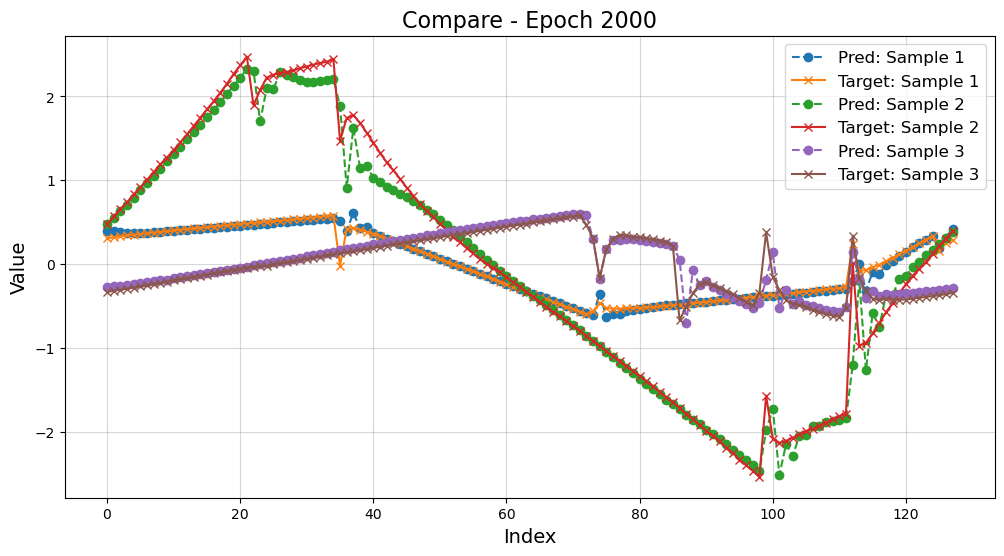

Epoch 2001, Train Loss: 0.043866, Validation Loss: 0.060598
Epoch 2002, Train Loss: 0.044161, Validation Loss: 0.059622
Epoch 2003, Train Loss: 0.044894, Validation Loss: 0.059830
Epoch 2004, Train Loss: 0.043482, Validation Loss: 0.059647
Epoch 2005, Train Loss: 0.043802, Validation Loss: 0.059494
Epoch 2006, Train Loss: 0.045114, Validation Loss: 0.061002
Epoch 2007, Train Loss: 0.045001, Validation Loss: 0.061179
Epoch 2008, Train Loss: 0.044931, Validation Loss: 0.060154
Epoch 2009, Train Loss: 0.044012, Validation Loss: 0.059624
Epoch 2010, Train Loss: 0.044175, Validation Loss: 0.059831
Epoch 2011, Train Loss: 0.044361, Validation Loss: 0.061100
Epoch 2012, Train Loss: 0.043161, Validation Loss: 0.059107
Saving model at epoch 2012 with validation loss 0.059107...
Epoch 2013, Train Loss: 0.043634, Validation Loss: 0.059609
Epoch 2014, Train Loss: 0.044835, Validation Loss: 0.060261
Epoch 2015, Train Loss: 0.044001, Validation Loss: 0.058718
Saving model at epoch 2015 with validati

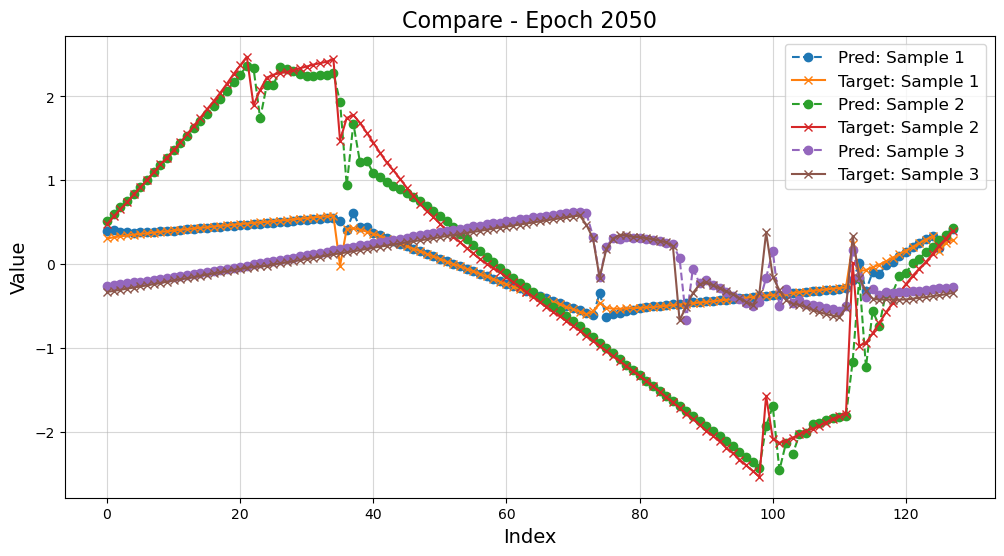

Epoch 2051, Train Loss: 0.042822, Validation Loss: 0.058928
Epoch 2052, Train Loss: 0.042721, Validation Loss: 0.058875
Epoch 2053, Train Loss: 0.043946, Validation Loss: 0.058959
Epoch 2054, Train Loss: 0.043396, Validation Loss: 0.059279
Epoch 2055, Train Loss: 0.044945, Validation Loss: 0.060405
Epoch 2056, Train Loss: 0.043657, Validation Loss: 0.060233
Epoch 2057, Train Loss: 0.045781, Validation Loss: 0.059210
Epoch 2058, Train Loss: 0.044209, Validation Loss: 0.058982
Epoch 2059, Train Loss: 0.043897, Validation Loss: 0.058653
Saving model at epoch 2059 with validation loss 0.058653...
Epoch 2060, Train Loss: 0.044391, Validation Loss: 0.059739
Epoch 2061, Train Loss: 0.043543, Validation Loss: 0.058961
Epoch 2062, Train Loss: 0.043206, Validation Loss: 0.058470
Saving model at epoch 2062 with validation loss 0.058470...
Epoch 2063, Train Loss: 0.043134, Validation Loss: 0.059065
Epoch 2064, Train Loss: 0.045580, Validation Loss: 0.062249
Epoch 2065, Train Loss: 0.047565, Valida

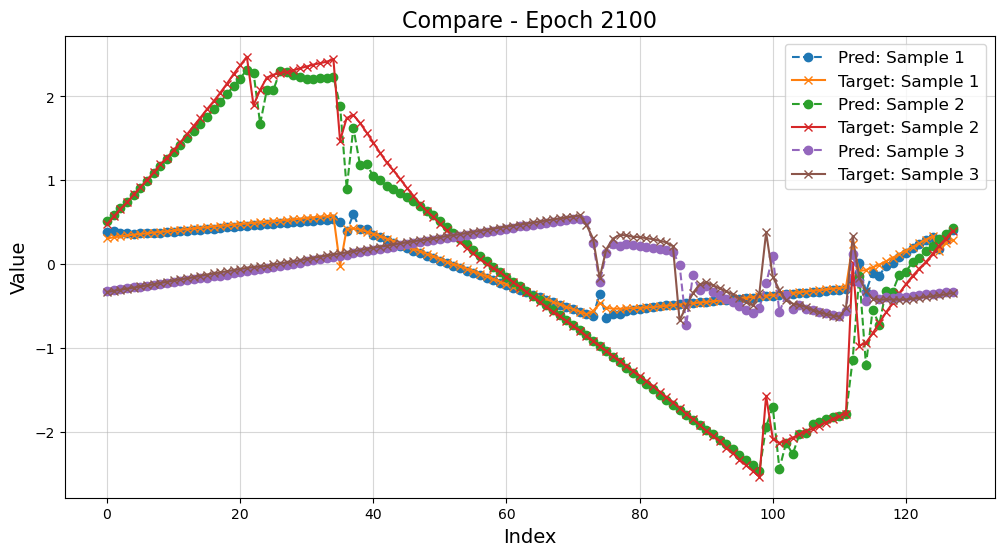

Epoch 2101, Train Loss: 0.042654, Validation Loss: 0.060639
Epoch 2102, Train Loss: 0.043606, Validation Loss: 0.061879
Epoch 2103, Train Loss: 0.043810, Validation Loss: 0.058138
Saving model at epoch 2103 with validation loss 0.058138...
Epoch 2104, Train Loss: 0.042737, Validation Loss: 0.058850
Epoch 2105, Train Loss: 0.043095, Validation Loss: 0.059363
Epoch 2106, Train Loss: 0.044137, Validation Loss: 0.058554
Epoch 2107, Train Loss: 0.042382, Validation Loss: 0.058667
Epoch 2108, Train Loss: 0.043282, Validation Loss: 0.059175
Epoch 2109, Train Loss: 0.043696, Validation Loss: 0.058473
Epoch 2110, Train Loss: 0.043186, Validation Loss: 0.059079
Epoch 2111, Train Loss: 0.043908, Validation Loss: 0.062021
Epoch 2112, Train Loss: 0.046905, Validation Loss: 0.063364
Epoch 2113, Train Loss: 0.044695, Validation Loss: 0.059659
Epoch 2114, Train Loss: 0.043232, Validation Loss: 0.058824
Epoch 2115, Train Loss: 0.043399, Validation Loss: 0.058477
Epoch 2116, Train Loss: 0.043500, Valida

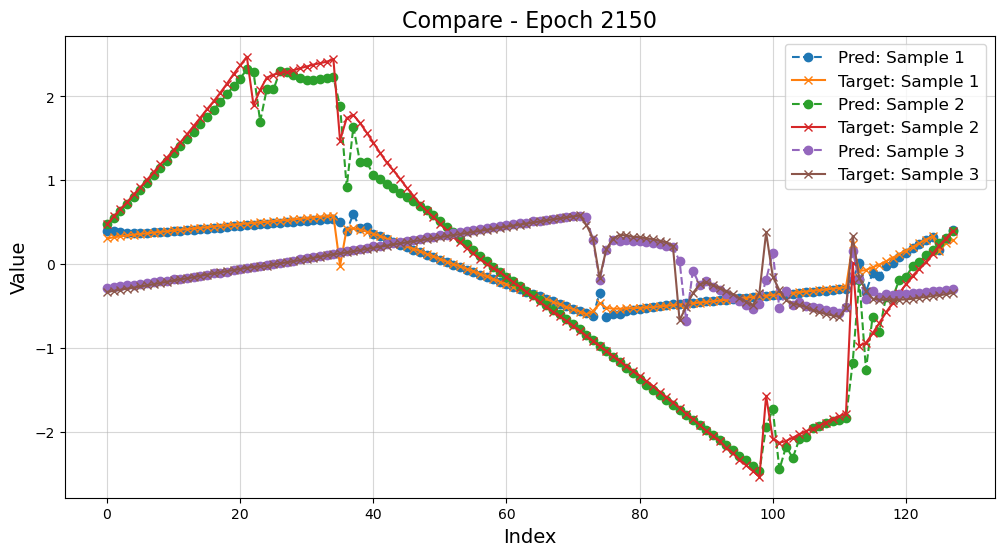

Epoch 2151, Train Loss: 0.042652, Validation Loss: 0.058123
Epoch 2152, Train Loss: 0.044425, Validation Loss: 0.058304
Epoch 2153, Train Loss: 0.042831, Validation Loss: 0.057845
Epoch 2154, Train Loss: 0.043496, Validation Loss: 0.059728
Epoch 2155, Train Loss: 0.042463, Validation Loss: 0.059203
Epoch 2156, Train Loss: 0.044255, Validation Loss: 0.059103
Epoch 2157, Train Loss: 0.042362, Validation Loss: 0.057726
Epoch 2158, Train Loss: 0.042655, Validation Loss: 0.057925
Epoch 2159, Train Loss: 0.042046, Validation Loss: 0.058500
Epoch 2160, Train Loss: 0.043587, Validation Loss: 0.057791
Epoch 2161, Train Loss: 0.043640, Validation Loss: 0.058093
Epoch 2162, Train Loss: 0.042405, Validation Loss: 0.058268
Epoch 2163, Train Loss: 0.042905, Validation Loss: 0.057606
Epoch 2164, Train Loss: 0.042302, Validation Loss: 0.058780
Epoch 2165, Train Loss: 0.043461, Validation Loss: 0.058010
Epoch 2166, Train Loss: 0.042828, Validation Loss: 0.059708
Epoch 2167, Train Loss: 0.043520, Valida

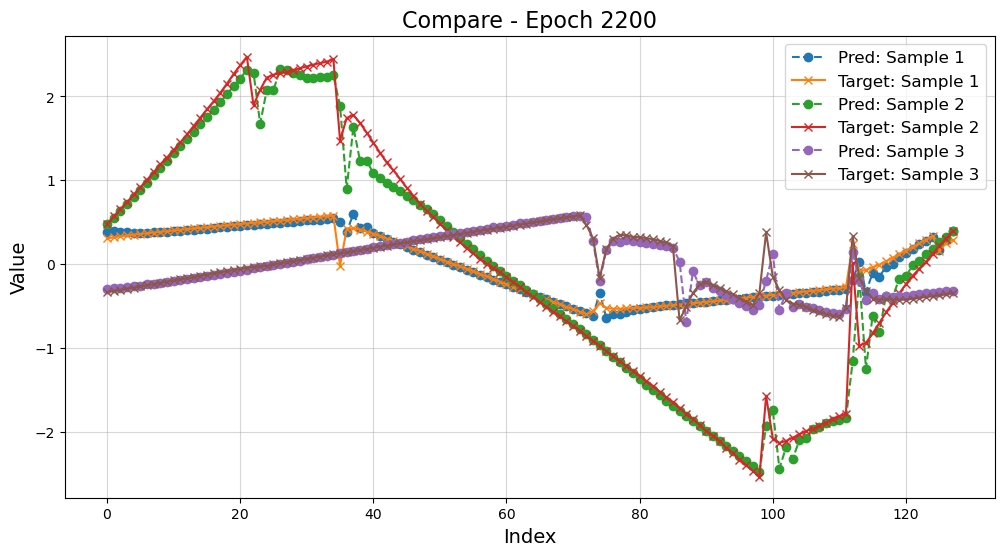

Epoch 2201, Train Loss: 0.042834, Validation Loss: 0.058202
Epoch 2202, Train Loss: 0.042978, Validation Loss: 0.057760
Epoch 2203, Train Loss: 0.042742, Validation Loss: 0.058025
Epoch 2204, Train Loss: 0.042509, Validation Loss: 0.058282
Epoch 2205, Train Loss: 0.042818, Validation Loss: 0.057737
Epoch 2206, Train Loss: 0.043789, Validation Loss: 0.057752
Epoch 2207, Train Loss: 0.043371, Validation Loss: 0.059372
Epoch 2208, Train Loss: 0.043202, Validation Loss: 0.058348
Epoch 2209, Train Loss: 0.043626, Validation Loss: 0.058248
Epoch 2210, Train Loss: 0.043610, Validation Loss: 0.057373
Saving model at epoch 2210 with validation loss 0.057373...
Epoch 2211, Train Loss: 0.043811, Validation Loss: 0.057282
Saving model at epoch 2211 with validation loss 0.057282...
Epoch 2212, Train Loss: 0.042196, Validation Loss: 0.058295
Epoch 2213, Train Loss: 0.042402, Validation Loss: 0.058585
Epoch 2214, Train Loss: 0.042189, Validation Loss: 0.058961
Epoch 2215, Train Loss: 0.043933, Valida

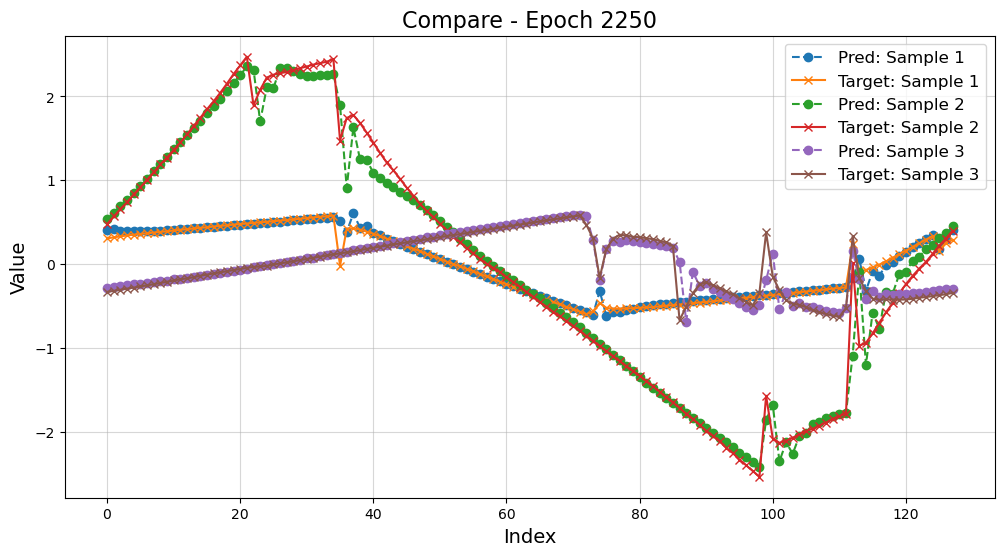

Epoch 2251, Train Loss: 0.041931, Validation Loss: 0.057206
Epoch 2252, Train Loss: 0.041332, Validation Loss: 0.057144
Epoch 2253, Train Loss: 0.042480, Validation Loss: 0.057140
Epoch 2254, Train Loss: 0.043020, Validation Loss: 0.059239
Epoch 2255, Train Loss: 0.042646, Validation Loss: 0.058358
Epoch 2256, Train Loss: 0.041931, Validation Loss: 0.056939
Saving model at epoch 2256 with validation loss 0.056939...
Epoch 2257, Train Loss: 0.041847, Validation Loss: 0.057015
Epoch 2258, Train Loss: 0.041764, Validation Loss: 0.058507
Epoch 2259, Train Loss: 0.043356, Validation Loss: 0.057310
Epoch 2260, Train Loss: 0.042580, Validation Loss: 0.057156
Epoch 2261, Train Loss: 0.041262, Validation Loss: 0.057328
Epoch 2262, Train Loss: 0.041769, Validation Loss: 0.057685
Epoch 2263, Train Loss: 0.042140, Validation Loss: 0.057067
Epoch 2264, Train Loss: 0.042764, Validation Loss: 0.058082
Epoch 2265, Train Loss: 0.042344, Validation Loss: 0.060914
Epoch 2266, Train Loss: 0.044571, Valida

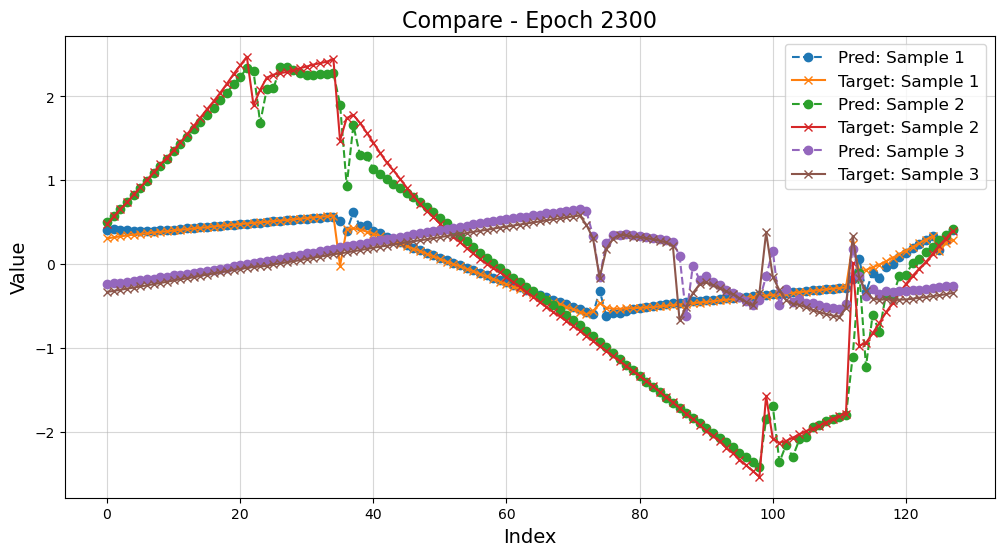

Epoch 2301, Train Loss: 0.042183, Validation Loss: 0.056641
Saving model at epoch 2301 with validation loss 0.056641...
Epoch 2302, Train Loss: 0.042481, Validation Loss: 0.057686
Epoch 2303, Train Loss: 0.041314, Validation Loss: 0.057280
Epoch 2304, Train Loss: 0.041404, Validation Loss: 0.056429
Saving model at epoch 2304 with validation loss 0.056429...
Epoch 2305, Train Loss: 0.041540, Validation Loss: 0.057090
Epoch 2306, Train Loss: 0.042149, Validation Loss: 0.057817
Epoch 2307, Train Loss: 0.041855, Validation Loss: 0.056992
Epoch 2308, Train Loss: 0.041729, Validation Loss: 0.057464
Epoch 2309, Train Loss: 0.041647, Validation Loss: 0.057541
Epoch 2310, Train Loss: 0.043026, Validation Loss: 0.058096
Epoch 2311, Train Loss: 0.041752, Validation Loss: 0.056571
Epoch 2312, Train Loss: 0.041114, Validation Loss: 0.058228
Epoch 2313, Train Loss: 0.042399, Validation Loss: 0.057939
Epoch 2314, Train Loss: 0.041811, Validation Loss: 0.057085
Epoch 2315, Train Loss: 0.042046, Valida

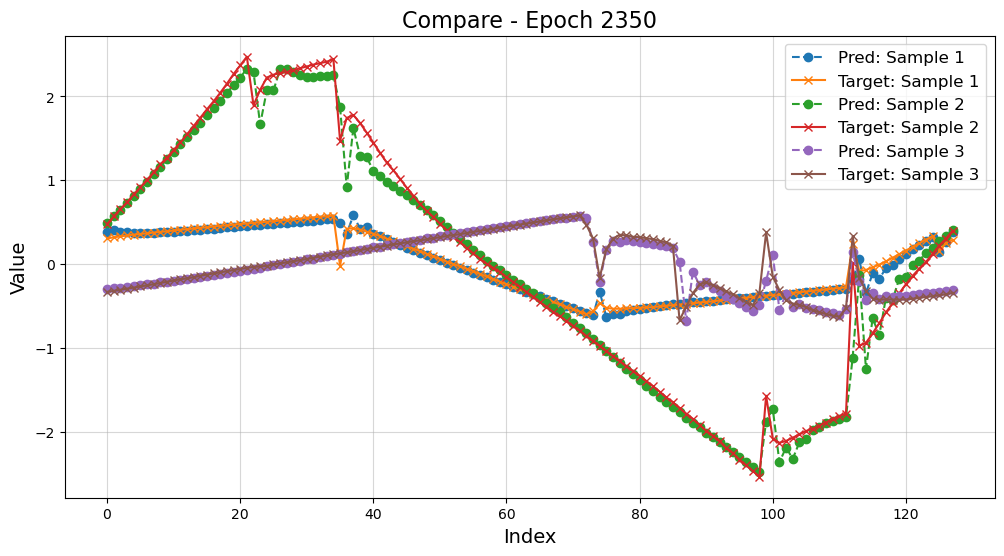

Epoch 2351, Train Loss: 0.043845, Validation Loss: 0.056902
Epoch 2352, Train Loss: 0.041921, Validation Loss: 0.056258
Epoch 2353, Train Loss: 0.041955, Validation Loss: 0.056791
Epoch 2354, Train Loss: 0.041466, Validation Loss: 0.056610
Epoch 2355, Train Loss: 0.041270, Validation Loss: 0.056428
Epoch 2356, Train Loss: 0.041493, Validation Loss: 0.056613
Epoch 2357, Train Loss: 0.041530, Validation Loss: 0.057227
Epoch 2358, Train Loss: 0.040967, Validation Loss: 0.056011
Saving model at epoch 2358 with validation loss 0.056011...
Epoch 2359, Train Loss: 0.040701, Validation Loss: 0.059534
Epoch 2360, Train Loss: 0.043606, Validation Loss: 0.057994
Epoch 2361, Train Loss: 0.041908, Validation Loss: 0.057385
Epoch 2362, Train Loss: 0.040973, Validation Loss: 0.056315
Epoch 2363, Train Loss: 0.040392, Validation Loss: 0.056226
Epoch 2364, Train Loss: 0.041321, Validation Loss: 0.056811
Epoch 2365, Train Loss: 0.042062, Validation Loss: 0.058304
Epoch 2366, Train Loss: 0.042317, Valida

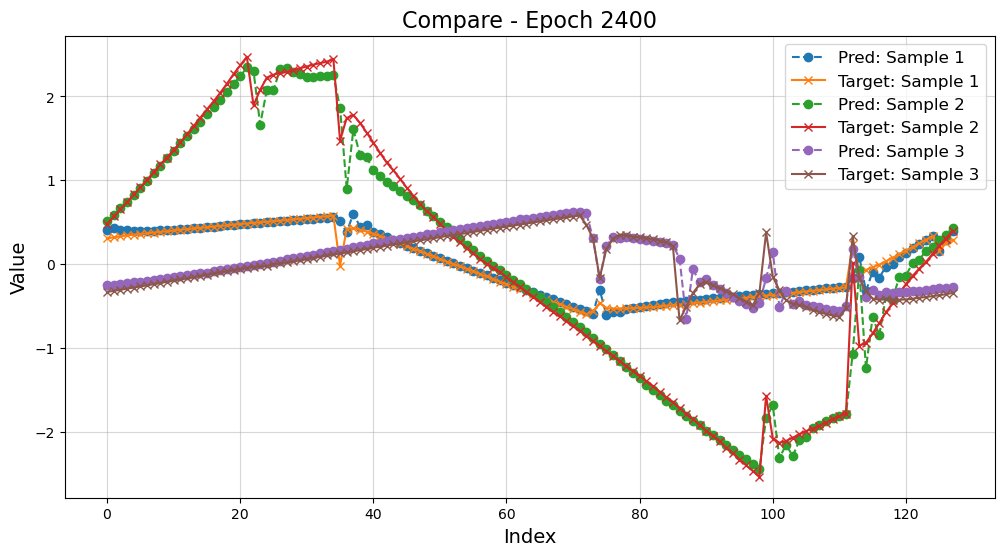

Epoch 2401, Train Loss: 0.040837, Validation Loss: 0.057945
Epoch 2402, Train Loss: 0.042162, Validation Loss: 0.056534
Epoch 2403, Train Loss: 0.039995, Validation Loss: 0.056160
Epoch 2404, Train Loss: 0.041081, Validation Loss: 0.056787
Epoch 2405, Train Loss: 0.042183, Validation Loss: 0.056486
Epoch 2406, Train Loss: 0.040600, Validation Loss: 0.055555
Saving model at epoch 2406 with validation loss 0.055555...
Epoch 2407, Train Loss: 0.040913, Validation Loss: 0.055418
Saving model at epoch 2407 with validation loss 0.055418...
Epoch 2408, Train Loss: 0.040208, Validation Loss: 0.056110
Epoch 2409, Train Loss: 0.040279, Validation Loss: 0.056840
Epoch 2410, Train Loss: 0.042154, Validation Loss: 0.055716
Epoch 2411, Train Loss: 0.040017, Validation Loss: 0.057211
Epoch 2412, Train Loss: 0.041168, Validation Loss: 0.056399
Epoch 2413, Train Loss: 0.041929, Validation Loss: 0.055815
Epoch 2414, Train Loss: 0.042349, Validation Loss: 0.055864
Epoch 2415, Train Loss: 0.042021, Valida

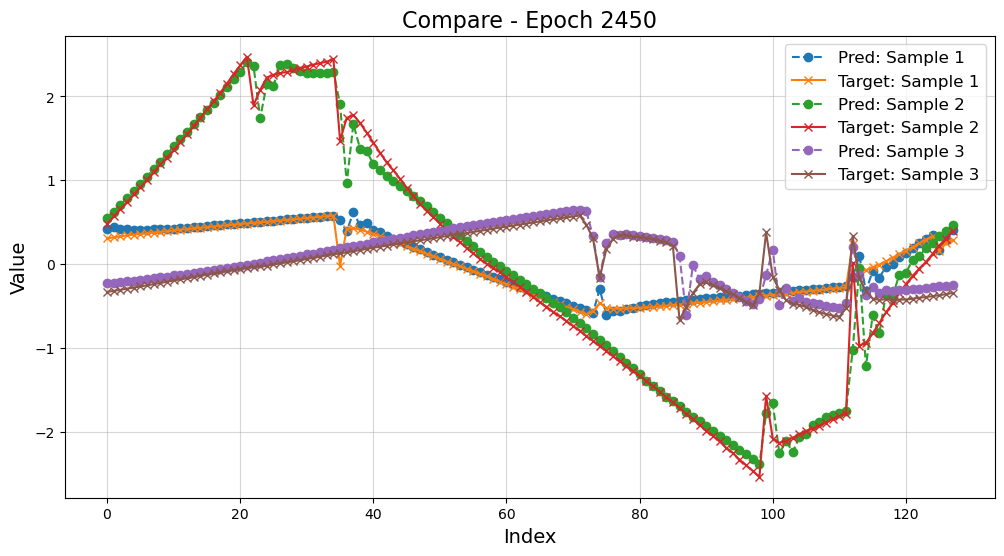

Epoch 2451, Train Loss: 0.041474, Validation Loss: 0.055431
Epoch 2452, Train Loss: 0.041108, Validation Loss: 0.055820
Epoch 2453, Train Loss: 0.041509, Validation Loss: 0.056587
Epoch 2454, Train Loss: 0.041365, Validation Loss: 0.057801
Epoch 2455, Train Loss: 0.042968, Validation Loss: 0.057430
Epoch 2456, Train Loss: 0.043293, Validation Loss: 0.058733
Epoch 2457, Train Loss: 0.041076, Validation Loss: 0.055370
Saving model at epoch 2457 with validation loss 0.055370...
Epoch 2458, Train Loss: 0.041186, Validation Loss: 0.055938
Epoch 2459, Train Loss: 0.040785, Validation Loss: 0.057103
Epoch 2460, Train Loss: 0.041860, Validation Loss: 0.056570
Epoch 2461, Train Loss: 0.041949, Validation Loss: 0.055914
Epoch 2462, Train Loss: 0.041075, Validation Loss: 0.056408
Epoch 2463, Train Loss: 0.041065, Validation Loss: 0.055918
Epoch 2464, Train Loss: 0.039960, Validation Loss: 0.055211
Saving model at epoch 2464 with validation loss 0.055211...
Epoch 2465, Train Loss: 0.040511, Valida

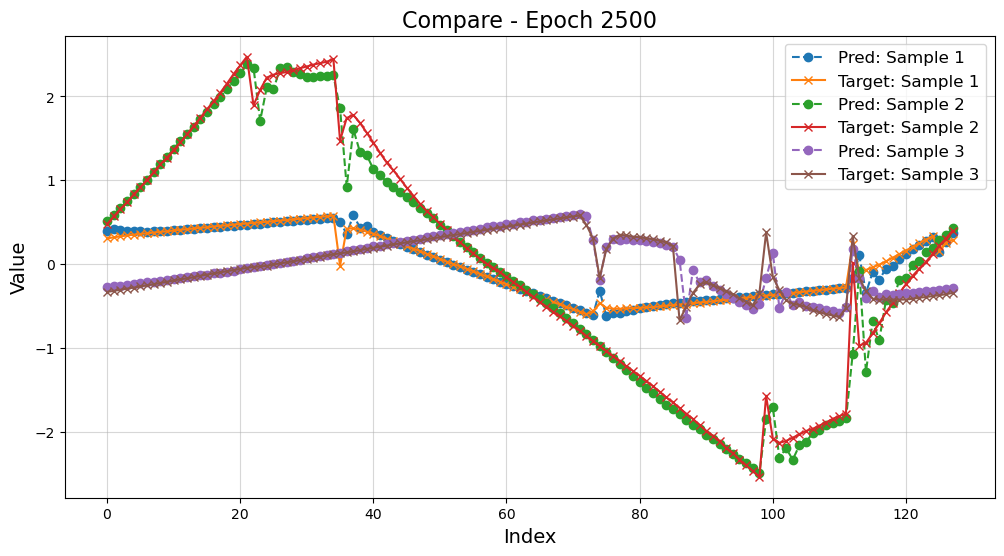

Epoch 2501, Train Loss: 0.039734, Validation Loss: 0.055227
Epoch 2502, Train Loss: 0.040703, Validation Loss: 0.055774
Epoch 2503, Train Loss: 0.041188, Validation Loss: 0.056615
Epoch 2504, Train Loss: 0.041869, Validation Loss: 0.057316
Epoch 2505, Train Loss: 0.042134, Validation Loss: 0.055188
Epoch 2506, Train Loss: 0.040861, Validation Loss: 0.056247
Epoch 2507, Train Loss: 0.040332, Validation Loss: 0.055512
Epoch 2508, Train Loss: 0.040797, Validation Loss: 0.055872
Epoch 2509, Train Loss: 0.040474, Validation Loss: 0.055146
Epoch 2510, Train Loss: 0.041999, Validation Loss: 0.055429
Epoch 2511, Train Loss: 0.039620, Validation Loss: 0.055192
Epoch 2512, Train Loss: 0.041740, Validation Loss: 0.054770
Saving model at epoch 2512 with validation loss 0.054770...
Epoch 2513, Train Loss: 0.040085, Validation Loss: 0.054955
Epoch 2514, Train Loss: 0.040949, Validation Loss: 0.055654
Epoch 2515, Train Loss: 0.040132, Validation Loss: 0.055020
Epoch 2516, Train Loss: 0.040573, Valida

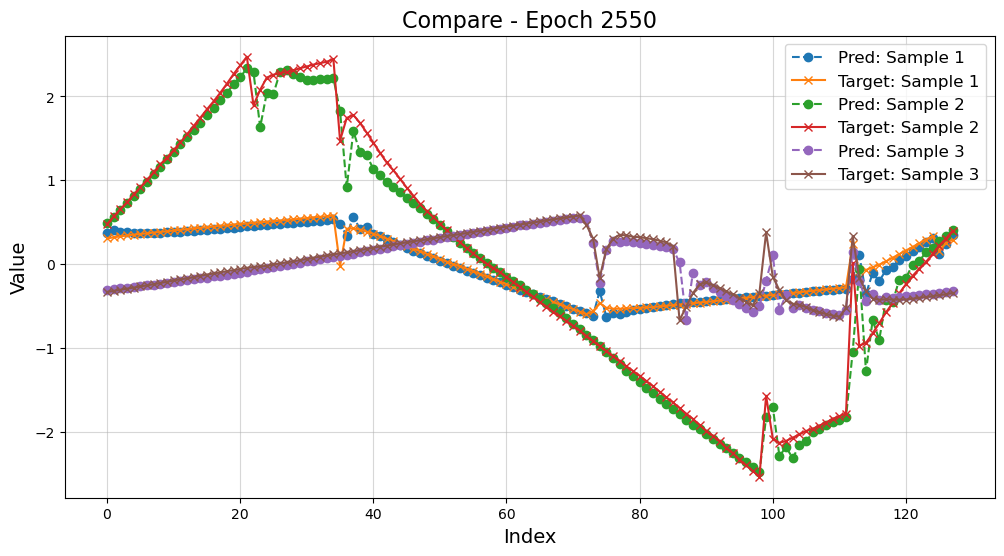

Epoch 2551, Train Loss: 0.040274, Validation Loss: 0.054218
Saving model at epoch 2551 with validation loss 0.054218...
Epoch 2552, Train Loss: 0.039435, Validation Loss: 0.055055
Epoch 2553, Train Loss: 0.040546, Validation Loss: 0.054917
Epoch 2554, Train Loss: 0.040408, Validation Loss: 0.054776
Epoch 2555, Train Loss: 0.039089, Validation Loss: 0.054615
Epoch 2556, Train Loss: 0.041185, Validation Loss: 0.054933
Epoch 2557, Train Loss: 0.039626, Validation Loss: 0.054745
Epoch 2558, Train Loss: 0.041318, Validation Loss: 0.054959
Epoch 2559, Train Loss: 0.040686, Validation Loss: 0.055615
Epoch 2560, Train Loss: 0.040051, Validation Loss: 0.055023
Epoch 2561, Train Loss: 0.039515, Validation Loss: 0.054800
Epoch 2562, Train Loss: 0.039235, Validation Loss: 0.054870
Epoch 2563, Train Loss: 0.040499, Validation Loss: 0.054718
Epoch 2564, Train Loss: 0.039530, Validation Loss: 0.054384
Epoch 2565, Train Loss: 0.041474, Validation Loss: 0.055241
Epoch 2566, Train Loss: 0.042140, Valida

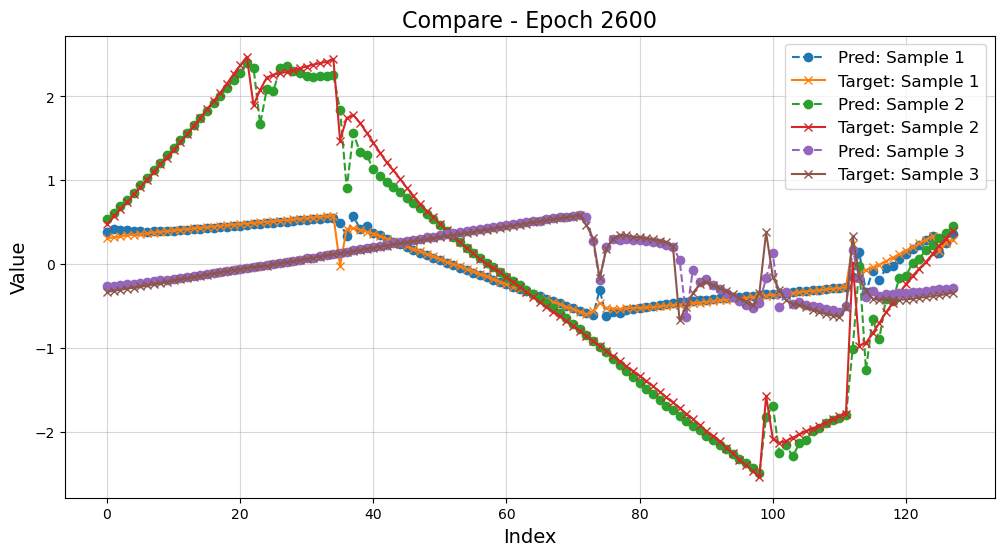

Epoch 2601, Train Loss: 0.040852, Validation Loss: 0.054339
Epoch 2602, Train Loss: 0.039413, Validation Loss: 0.054878
Epoch 2603, Train Loss: 0.040186, Validation Loss: 0.053683
Saving model at epoch 2603 with validation loss 0.053683...
Epoch 2604, Train Loss: 0.039928, Validation Loss: 0.055774
Epoch 2605, Train Loss: 0.040771, Validation Loss: 0.054732
Epoch 2606, Train Loss: 0.039996, Validation Loss: 0.056527
Epoch 2607, Train Loss: 0.039633, Validation Loss: 0.054025
Epoch 2608, Train Loss: 0.039191, Validation Loss: 0.054599
Epoch 2609, Train Loss: 0.038650, Validation Loss: 0.053914
Epoch 2610, Train Loss: 0.038847, Validation Loss: 0.053926
Epoch 2611, Train Loss: 0.040184, Validation Loss: 0.054335
Epoch 2612, Train Loss: 0.040617, Validation Loss: 0.054578
Epoch 2613, Train Loss: 0.039113, Validation Loss: 0.054570
Epoch 2614, Train Loss: 0.039173, Validation Loss: 0.054814
Epoch 2615, Train Loss: 0.039867, Validation Loss: 0.055008
Epoch 2616, Train Loss: 0.039044, Valida

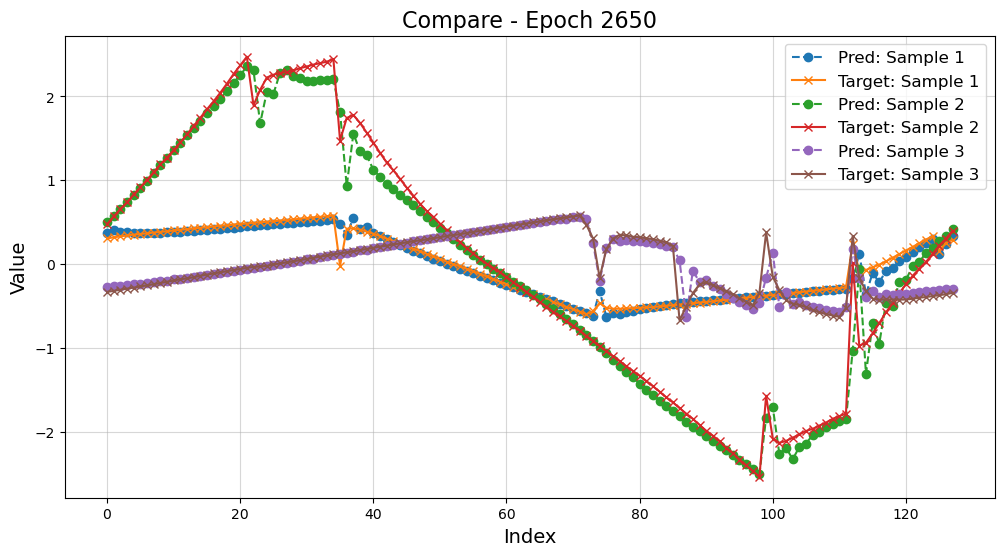

Epoch 2651, Train Loss: 0.040271, Validation Loss: 0.054339
Epoch 2652, Train Loss: 0.039627, Validation Loss: 0.053873
Epoch 2653, Train Loss: 0.039460, Validation Loss: 0.056164
Epoch 2654, Train Loss: 0.041063, Validation Loss: 0.057208
Epoch 2655, Train Loss: 0.040340, Validation Loss: 0.057037
Epoch 2656, Train Loss: 0.040694, Validation Loss: 0.054814
Epoch 2657, Train Loss: 0.040097, Validation Loss: 0.054364
Epoch 2658, Train Loss: 0.038877, Validation Loss: 0.054124
Epoch 2659, Train Loss: 0.039619, Validation Loss: 0.053961
Epoch 2660, Train Loss: 0.039082, Validation Loss: 0.055343
Epoch 2661, Train Loss: 0.039818, Validation Loss: 0.054964
Epoch 2662, Train Loss: 0.039694, Validation Loss: 0.053983
Epoch 2663, Train Loss: 0.038954, Validation Loss: 0.053540
Epoch 2664, Train Loss: 0.039078, Validation Loss: 0.054982
Epoch 2665, Train Loss: 0.040166, Validation Loss: 0.053841
Epoch 2666, Train Loss: 0.039538, Validation Loss: 0.053671
Epoch 2667, Train Loss: 0.039452, Valida

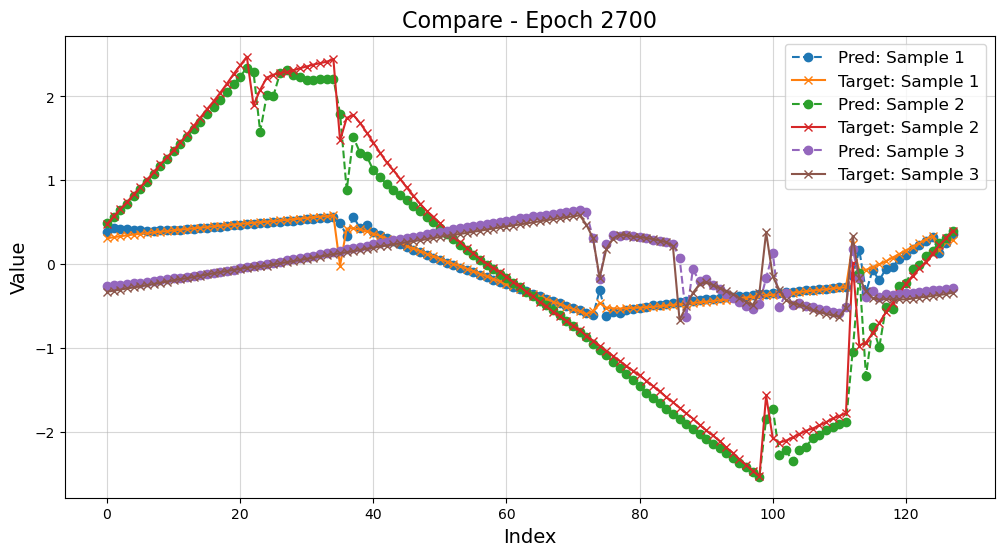

Epoch 2701, Train Loss: 0.040502, Validation Loss: 0.055503
Epoch 2702, Train Loss: 0.040543, Validation Loss: 0.053232
Epoch 2703, Train Loss: 0.039046, Validation Loss: 0.054601
Epoch 2704, Train Loss: 0.038905, Validation Loss: 0.053355
Epoch 2705, Train Loss: 0.039458, Validation Loss: 0.053530
Epoch 2706, Train Loss: 0.039268, Validation Loss: 0.054649
Epoch 2707, Train Loss: 0.039361, Validation Loss: 0.054033
Epoch 2708, Train Loss: 0.039462, Validation Loss: 0.053458
Epoch 2709, Train Loss: 0.039480, Validation Loss: 0.054714
Epoch 2710, Train Loss: 0.040373, Validation Loss: 0.053294
Epoch 2711, Train Loss: 0.040547, Validation Loss: 0.053358
Epoch 2712, Train Loss: 0.039343, Validation Loss: 0.053077
Saving model at epoch 2712 with validation loss 0.053077...
Epoch 2713, Train Loss: 0.039582, Validation Loss: 0.053660
Epoch 2714, Train Loss: 0.038187, Validation Loss: 0.052945
Saving model at epoch 2714 with validation loss 0.052945...
Epoch 2715, Train Loss: 0.038187, Valida

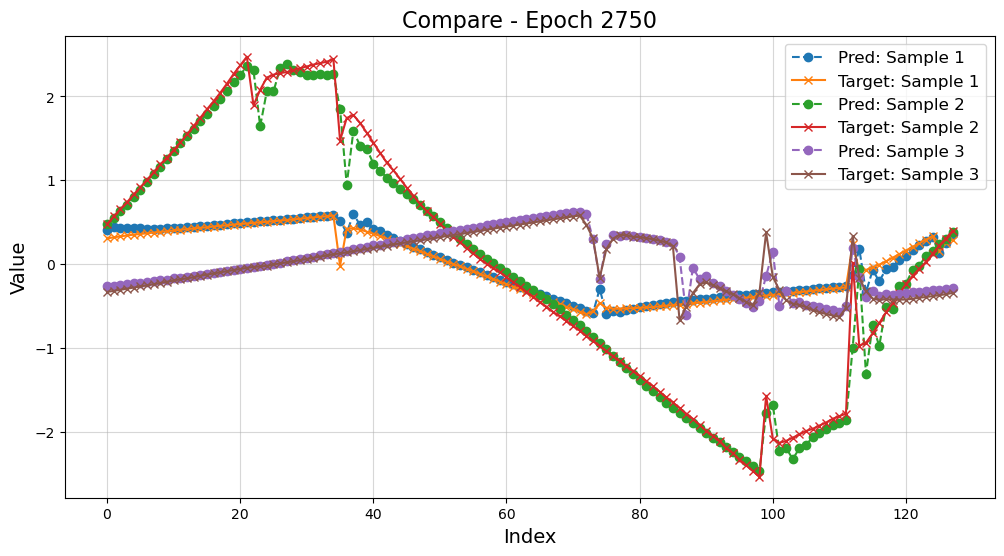

Epoch 2751, Train Loss: 0.039811, Validation Loss: 0.053620
Epoch 2752, Train Loss: 0.039094, Validation Loss: 0.053155
Epoch 2753, Train Loss: 0.038607, Validation Loss: 0.052635
Saving model at epoch 2753 with validation loss 0.052635...
Epoch 2754, Train Loss: 0.038127, Validation Loss: 0.052758
Epoch 2755, Train Loss: 0.037963, Validation Loss: 0.053068
Epoch 2756, Train Loss: 0.038846, Validation Loss: 0.052784
Epoch 2757, Train Loss: 0.038829, Validation Loss: 0.053368
Epoch 2758, Train Loss: 0.040797, Validation Loss: 0.052583
Saving model at epoch 2758 with validation loss 0.052583...
Epoch 2759, Train Loss: 0.038266, Validation Loss: 0.052608
Epoch 2760, Train Loss: 0.041329, Validation Loss: 0.053478
Epoch 2761, Train Loss: 0.039590, Validation Loss: 0.053253
Epoch 2762, Train Loss: 0.038307, Validation Loss: 0.054883
Epoch 2763, Train Loss: 0.039790, Validation Loss: 0.053952
Epoch 2764, Train Loss: 0.040634, Validation Loss: 0.052740
Epoch 2765, Train Loss: 0.039259, Valida

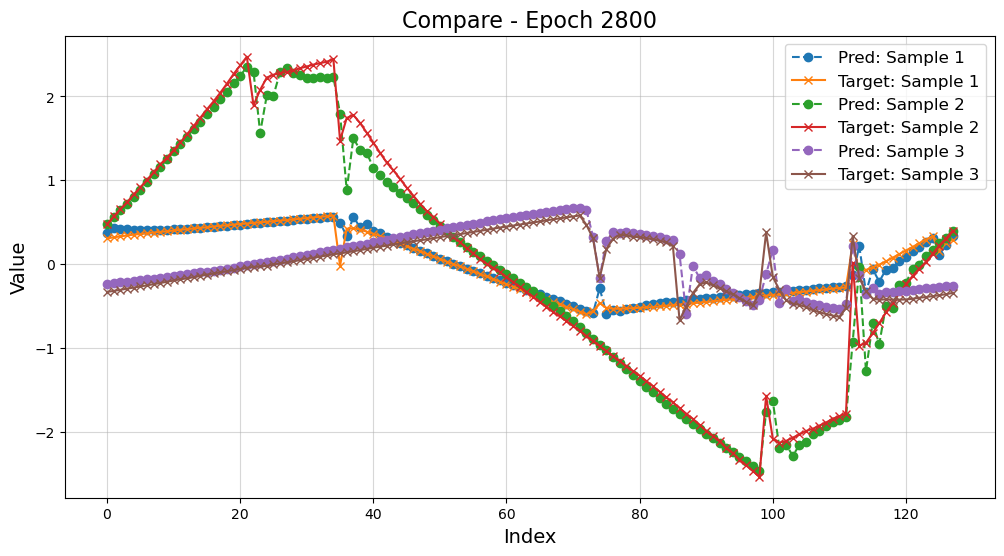

Epoch 2801, Train Loss: 0.038824, Validation Loss: 0.053975
Epoch 2802, Train Loss: 0.038169, Validation Loss: 0.052341
Epoch 2803, Train Loss: 0.038129, Validation Loss: 0.053230
Epoch 2804, Train Loss: 0.039805, Validation Loss: 0.052491
Epoch 2805, Train Loss: 0.037887, Validation Loss: 0.052459
Epoch 2806, Train Loss: 0.040025, Validation Loss: 0.052968
Epoch 2807, Train Loss: 0.039543, Validation Loss: 0.053151
Epoch 2808, Train Loss: 0.039380, Validation Loss: 0.053293
Epoch 2809, Train Loss: 0.039313, Validation Loss: 0.052833
Epoch 2810, Train Loss: 0.038305, Validation Loss: 0.052572
Epoch 2811, Train Loss: 0.038147, Validation Loss: 0.053988
Epoch 2812, Train Loss: 0.039435, Validation Loss: 0.054331
Epoch 2813, Train Loss: 0.038608, Validation Loss: 0.053638
Epoch 2814, Train Loss: 0.039392, Validation Loss: 0.051945
Saving model at epoch 2814 with validation loss 0.051945...
Epoch 2815, Train Loss: 0.038363, Validation Loss: 0.053393
Epoch 2816, Train Loss: 0.038405, Valida

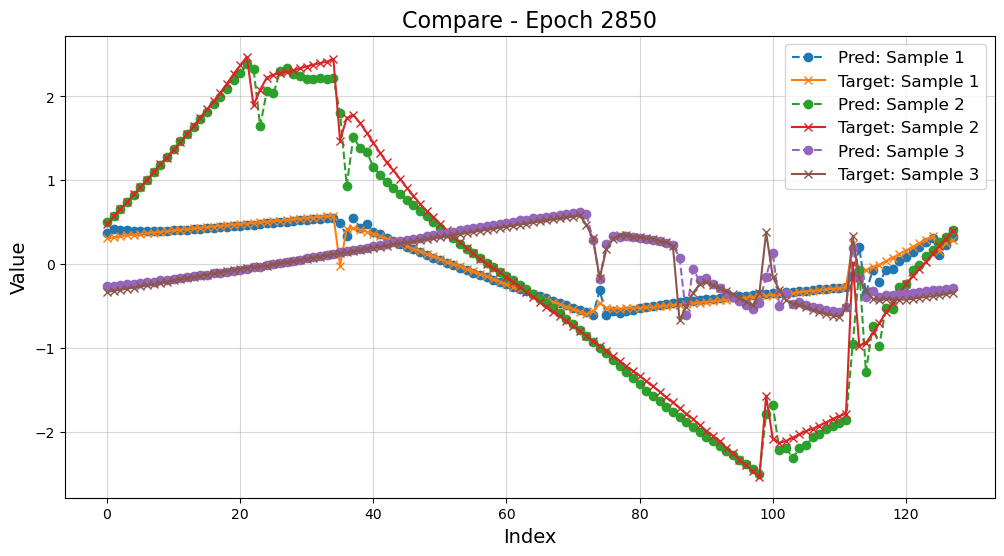

Epoch 2851, Train Loss: 0.037997, Validation Loss: 0.051976
Epoch 2852, Train Loss: 0.039275, Validation Loss: 0.057297
Epoch 2853, Train Loss: 0.041521, Validation Loss: 0.053815
Epoch 2854, Train Loss: 0.041600, Validation Loss: 0.054434
Epoch 2855, Train Loss: 0.039955, Validation Loss: 0.053087
Epoch 2856, Train Loss: 0.039521, Validation Loss: 0.053963
Epoch 2857, Train Loss: 0.038353, Validation Loss: 0.051941
Epoch 2858, Train Loss: 0.038233, Validation Loss: 0.051714
Epoch 2859, Train Loss: 0.038087, Validation Loss: 0.052155
Epoch 2860, Train Loss: 0.038425, Validation Loss: 0.052127
Epoch 2861, Train Loss: 0.037761, Validation Loss: 0.051794
Epoch 2862, Train Loss: 0.038692, Validation Loss: 0.052458
Epoch 2863, Train Loss: 0.038438, Validation Loss: 0.053221
Epoch 2864, Train Loss: 0.039406, Validation Loss: 0.052172
Epoch 2865, Train Loss: 0.038211, Validation Loss: 0.052000
Epoch 2866, Train Loss: 0.038420, Validation Loss: 0.051899
Epoch 2867, Train Loss: 0.037887, Valida

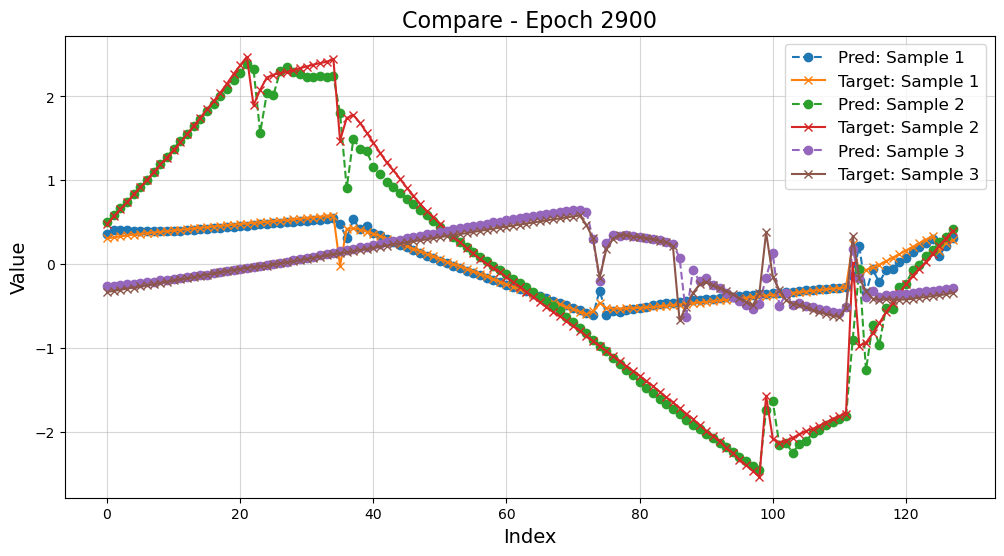

Epoch 2901, Train Loss: 0.041759, Validation Loss: 0.051371
Epoch 2902, Train Loss: 0.038591, Validation Loss: 0.051417
Epoch 2903, Train Loss: 0.037937, Validation Loss: 0.051806
Epoch 2904, Train Loss: 0.037063, Validation Loss: 0.051109
Epoch 2905, Train Loss: 0.037680, Validation Loss: 0.051448
Epoch 2906, Train Loss: 0.038272, Validation Loss: 0.051547
Epoch 2907, Train Loss: 0.038380, Validation Loss: 0.050944
Saving model at epoch 2907 with validation loss 0.050944...
Epoch 2908, Train Loss: 0.037562, Validation Loss: 0.052022
Epoch 2909, Train Loss: 0.037264, Validation Loss: 0.051799
Epoch 2910, Train Loss: 0.038157, Validation Loss: 0.051808
Epoch 2911, Train Loss: 0.037198, Validation Loss: 0.051141
Epoch 2912, Train Loss: 0.036667, Validation Loss: 0.051476
Epoch 2913, Train Loss: 0.038679, Validation Loss: 0.051013
Epoch 2914, Train Loss: 0.037466, Validation Loss: 0.051941
Epoch 2915, Train Loss: 0.036880, Validation Loss: 0.051344
Epoch 2916, Train Loss: 0.039014, Valida

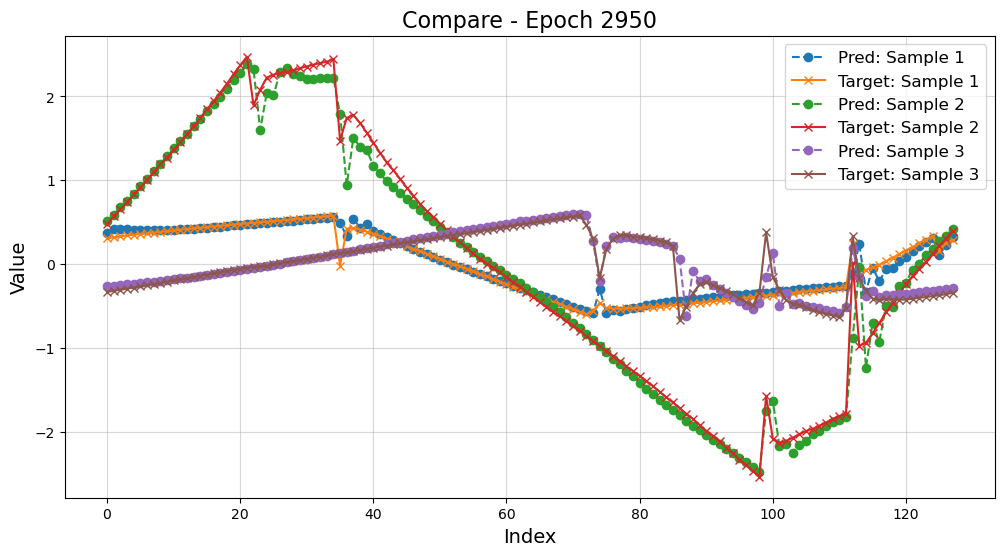

Epoch 2951, Train Loss: 0.038004, Validation Loss: 0.053215
Epoch 2952, Train Loss: 0.037520, Validation Loss: 0.050827
Epoch 2953, Train Loss: 0.040058, Validation Loss: 0.050841
Epoch 2954, Train Loss: 0.037671, Validation Loss: 0.051939
Epoch 2955, Train Loss: 0.038366, Validation Loss: 0.050559
Epoch 2956, Train Loss: 0.038036, Validation Loss: 0.054247
Epoch 2957, Train Loss: 0.039313, Validation Loss: 0.050664
Epoch 2958, Train Loss: 0.037570, Validation Loss: 0.051201
Epoch 2959, Train Loss: 0.038077, Validation Loss: 0.052491
Epoch 2960, Train Loss: 0.038447, Validation Loss: 0.052051
Epoch 2961, Train Loss: 0.037532, Validation Loss: 0.051205
Epoch 2962, Train Loss: 0.037981, Validation Loss: 0.051350
Epoch 2963, Train Loss: 0.037665, Validation Loss: 0.050276
Saving model at epoch 2963 with validation loss 0.050276...
Epoch 2964, Train Loss: 0.039018, Validation Loss: 0.050996
Epoch 2965, Train Loss: 0.037337, Validation Loss: 0.050998
Epoch 2966, Train Loss: 0.037420, Valida

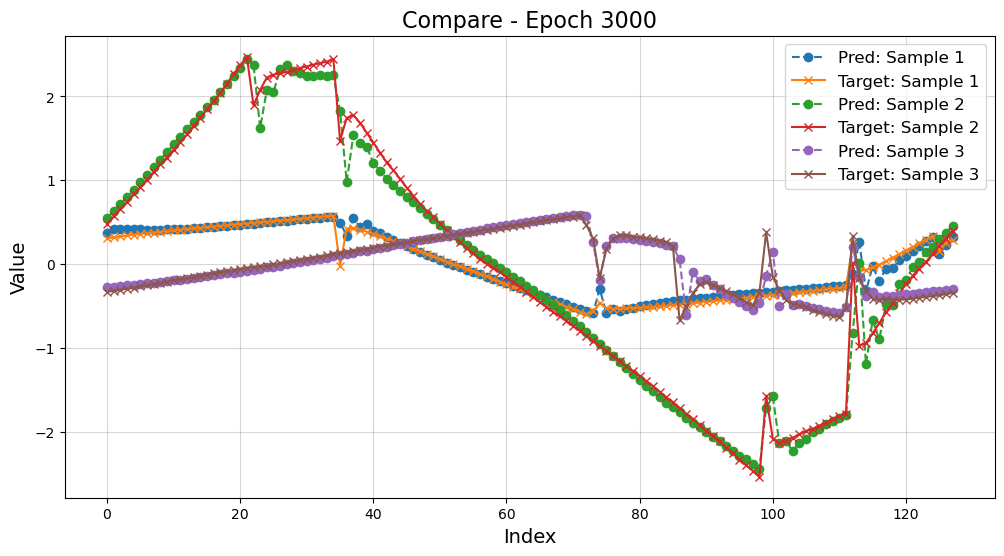

Training complete. Best model saved at ./Model/Material A.pt.


In [10]:
if __name__ == "__main__":

    data_B, data_F, data_T, data_H, data_Pcv = load_dataset(material)
    norm = normsDict[material]

    train_loader, valid_loader = get_dataloader(data_B, data_F, data_T, data_H,
                                                data_Pcv, norm)

    train_model(train_loader, valid_loader)